In [1]:
import subprocess
import sys

In [2]:
#noexport
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4"

In [3]:
from fastai.basics import *


Bad key "text.kerning_factor" on line 4 in
/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
if not IN_NOTEBOOK:
    class IPython():
        @staticmethod
        def system(cmd): print(subprocess.run(cmd.split(" "),text=True,capture_output=True).stdout)
    def get_ipython(): return IPython()
def install(package): subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [5]:
#noexport
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, IntSlider


In [6]:
import os

import torch
from fastai.vision.all import *
from fastai.distributed import *
import fastai
DistributedTrainer.fup=True #added
import sklearn.metrics as skm
import pandas as pd
#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 170)
#pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2

pd.set_option('display.max_columns', None)

from TMA_tools import Spot, TMA, WSI

#added
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import timm
from torchvision.models import *
from fastcore.script import *
import ast
import gc
from ast import literal_eval
import datatable as dt
import dcor
import seaborn as sns

In [7]:
#noexport
import fastai
fastai.__file__,fastai.__version__,torch.__version__

('/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/fastai/__init__.py',
 '2.1.5',
 '1.7.0')

In [9]:

#%run TMA_tools.ipynb

In [60]:
@call_parse
def main(
    lr:             Param("Learning rate", float)=1e-5, #0.00001
    bs:             Param("Batchs size",int)=32 * 4,
    test_slices:    Param("Number of partitions of each record during test",int)=100,
    test_bs:        Param("Batchs size in test",int)=100,
    epochs:         Param("Epochs", int)=3,
    fold:           Param("Fold", int)=0, #if -1 then it is an inmutable single fold (no k-Folds) 
    folds:          Param("Number of fold", int)=5,
    j:              Param("Num workers", int)=8,
    arch:           Param("Conv trunk architecture",str) = 'efficientnet_b3',
    fp16:           Param("fp16 method: to_fp16, to_non_native_fp16, none", str) = 'to_fp16',#'noop',
    mixover:        Param("Use mixover",action='store_true')=False,
    mixup:          Param("Use mixup",action='store_true')=False,
    coord:          Param("Use coordconv",action='store_true')=True,
    do:             Param("Spectral dropout", float)=0.5,
    jitter:         Param("Jitter, percentage of total length, e.g. 0.1", float)=0.,
    wn:             Param("White noise in dB, e.g. 4", float)=0.,

    fit:            Param("fit, fit_one_cycle, fit_flat_cos", str) = 'fit_one_cycle',
    fit_kwargs:     Param("Optional args for fit,eg pct_start=0.1", str, nargs='+') = {},

    opt:            Param("Optimizer", str) = 'Adam',
    opt_kwargs:     Param("Optional args for opt, eg. eps=1e-4", str, nargs='+') = {},
    
    sample_rate:    Param("",int)=48000,
    window_size:    Param("",int)=1024*2,
    hop_size:       Param("",int)=480,
    res_time:       Param("",int)=224*2,
    res_freq:       Param("",int)=256,
    
    ext:            Param("",str)="/home/auri/EPICOLON",
    
    #model:          Param("",str)="",
    task:           Param("",str,choices=['train','precache','ensemble'])="train",
    preds:          Param("Pred filenames",str,nargs='+')=[],
    pred_weights:   Param("Pred filenames",float,nargs='+')=None,
    
    pseudolabel_fns: Param("Pseudolabels files",str,nargs='+')=['pseudo.csv'],
    pseudolabels:    Param("Use pseudolabels",action='store_true')=False,

    local_rank:     Param("--local_rank",int)=None,
    nproc_per_node: Param("--nproc_per_node",int)=None,
    #added
    dataset:   Param('Dataset used for training', str, nargs='+') = ['epicolon_only_HGUA','epicolon_other'], # 'epicolon' ,'TCGA', 'epicolon_only_HGUA', 'epicolon_other'
    test:      Param('Dataset used for independent testing', str, nargs='+') = ['TCGA'], 
    weight:    Param('Class weighting', str) = 'label', # 'bias_label' 
    tissues:   Param('Type of tissues used for training', str, nargs='+')=['TUM','LYM','MUC'], #['TUM']['TUM','LYM','MUC']['TUM','STR', 'LYM', 'MUC']
    zoom_filter:  Param('Zoom level used for training', str)= None, # 0-4 in EPICOLON and 0-1 in TCGA. If None then all levels available
    pred_patient_img:  Param('Predict patient image with sliding tiles', action = 'store_true' ) = False,
    verbose:     Param("--verbose",bool)=False,
    test_saved_model:  Param('Name of the saved model for testing', str) = None, #if None then it will train a new model otherwise will test the saved model 
    control_bias:  Param('Control bias when training', int, nargs='*')=[1,2,3], #if empty then vanilla training, 1=control hospital bias, 2=control patient bias, 3=control TMA bias
    distillation_start:  Param('% of iterations in first epoch prior to bias distillation', int) = 0, #if 0 then distillation starts at the beginning  
    distillation_period:  Param('Number of iterations each bias distillation occurs', int) = 1, #if 1 then distillation is done on each iteration 
    lambda_coef: Param('Coeficcient to boost bias loss', int) = 10.,
    ablate: Param('Ablation group for glass bias training with statistical independence', str) = 'MSI', 
    frac: Param('Fraction of training dataset', int) = 1
): 
    if opt_kwargs: opt_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in opt_kwargs}
    if fit_kwargs: fit_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in fit_kwargs}
    print(locals())
    globals().update({ 'a' : AttrDict(locals())})

In [11]:
#noexport
main(fp16='to_fp16', verbose = True, dataset = ['epicolon_only_HGUA','epicolon_other'  ], test = ['TCGA'],  epochs = 3, weight = 'label',
     #test_saved_model = "0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=3_AUC=0.8840031751729733",
     control_bias = [], lambda_coef = 1., distillation_start = 0, distillation_period= 1 , frac = 1 )

{'lr': 1e-05, 'bs': 32, 'test_slices': 100, 'test_bs': 100, 'epochs': 3, 'fold': 0, 'folds': 5, 'j': 8, 'arch': 'efficientnet_b3', 'fp16': 'to_fp16', 'mixover': False, 'mixup': False, 'coord': True, 'do': 0.5, 'jitter': 0.0, 'wn': 0.0, 'fit': 'fit_one_cycle', 'fit_kwargs': {}, 'opt': 'Adam', 'opt_kwargs': {}, 'sample_rate': 48000, 'window_size': 2048, 'hop_size': 480, 'res_time': 448, 'res_freq': 256, 'ext': '/home/auri/EPICOLON', 'task': 'train', 'preds': [], 'pred_weights': None, 'pseudolabel_fns': ['pseudo.csv'], 'pseudolabels': False, 'local_rank': None, 'nproc_per_node': None, 'dataset': ['epicolon_only_HGUA', 'epicolon_other'], 'test': ['TCGA'], 'weight': 'label', 'tissues': ['TUM', 'LYM', 'MUC'], 'zoom_filter': None, 'pred_patient_img': False, 'verbose': True, 'test_saved_model': "0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=3_AUC=0.8840031751729733", 'control_bi

In [12]:
n_gpus = torch.cuda.device_count() if a.local_rank is None else 1
if a.local_rank is not None:
    torch.cuda.set_device(a.local_rank)
    torch.distributed.init_process_group(backend='nccl', init_method='env://')
    if a.j: a.j = min(1,a.j//num_distrib())
    print("DISTRIBUTED")

In [13]:
load_all_mean_rgb = True
cls = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
if not load_all_mean_rgb:
    __p_csv = Path('dataset_level_all_TMA20-013_no_overlap_labeled_tissue.csv') #HGUA samples from TMA20-013
    _p_csv = Path('dataset_level_all_March21_no_overlap_labeled_tissue.csv') #HGUA samples
    p_csv = Path('dataset_level_all_no_overlap_labeled_tissue.csv') #Epicolon I and II
    _p_csv_1 = Path('dataset_TCGA_MSI-H_level_0_no_overlap_labeled_tissue.csv') #TCGA MSI
    _p_csv_0 = Path('dataset_TCGA_MSS_level_0_no_overlap_labeled_tissue.csv') #TCGA MSS

    _d = pd.DataFrame()
    d_t = pd.DataFrame()
    de = pd.DataFrame()
    if 'TCGA' in a.dataset  or 'TCGA' in a.test:
        d_t = dt.fread(_p_csv_0).to_pandas()
        print(d_t.shape)
        _d_t = dt.fread(_p_csv_1).to_pandas()
        d_t = pd.concat([d_t,_d_t])
        d_t.shape #n tiles extracted from TCGA 
        d_t['project'] = 'TCGA'
        
        

    if any("epicolon" in s for s in a.dataset) or any("epicolon" in s for s in a.test):
        de = dt.fread(p_csv).to_pandas()
        print(de.shape)
        _d = dt.fread(_p_csv).to_pandas()
        __d = dt.fread(__p_csv).to_pandas()

        d = pd.concat([de,_d,__d])
        d.shape #n tiles extracted from EPICOLON I and II + HGUA  
        
        d['project'] = 'epicolon'

    d = pd.concat([d,d_t])
    
    
else: 
    d = pd.read_csv('saved.csv')
    
    d.drop(columns = 'Unnamed: 0', inplace = True )

d.shape

/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,5,6,7,9,11,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3150185, 15)

In [14]:
d.tif_fn.nunique(), d.svs_fn.nunique()

(62, 476)

In [15]:
 #EPICOLON I: 105 casos y EPICOLON II: 64 casos de HGUA

In [16]:
d = d.sample(frac = a.frac, random_state = 123)
#filter tiles with scarce tissue 
d = d.loc[d.mean_rgb <= 197]
#filter tiles from TMA20-013 (not well scanned, pending )
d = d.loc[d.tif_fn  != 'TMA20-013']
d.shape


(2744560, 15)

In [17]:

print(f'N patients IDs (if EPICOLON total is not disambiguated): {d.patient_ID.nunique()}, ( MSI {d.loc[d.label == 1].patient_ID.nunique()})')

N patients IDs (if EPICOLON total is not disambiguated): 2651, ( MSI 245)


In [18]:
def eval_fields(df):
    df.tile = df.tile.apply(lambda x: eval(str(x)))
    
    df.loc[df.project == 'epicolon', 'tile_rot_augmentation'] = df.loc[df.project == 'epicolon'].tile_rot_augmentation.apply(lambda x: eval(str(x)))
    return df
df_split = np.array_split(d, 32)

res = parallel(partial(eval_fields), df_split)
d = pd.concat([*res])



In [19]:
#noexport
d['zoom'] = d.tile.apply(lambda o: o[3])
d.zoom.value_counts()

0    2530335
1     159650
2      37999
3      13181
4       3395
Name: zoom, dtype: int64

In [20]:

d.patient_ID = d.patient_ID.astype(str)



In [21]:
#disambiguate IDs
if any("epicolon" in s for s in a.dataset) or any("epicolon" in s for s in a.test):
    #print(d[d.patient_ID.str.contains('.0', regex = False)].patient_ID.nunique())
    d.loc[d.project == 'epicolon', 'patient_ID'] = d.loc[d.project == 'epicolon'].patient_ID.str.replace('.0','', regex=False)
    d.loc[d.project == 'epicolon', 'patient_ID'] = d.loc[d.project == 'epicolon'].patient_ID.str.replace(r"[ABC]$",'', regex=True)
    d.loc[d.patient_ID == '06-13741', 'patient_ID'] = '06B0013741'
    d.loc[d.patient_ID == '07-002125', 'patient_ID']  ='07B0002125'
    d.loc[d.patient_ID == '06B0014684A'  , 'patient_ID']  ='06B0014584'

    #correct labels in two patients with mixed labels in source data (verified with AP)
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS 
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI (pending)
    d.loc[d.patient_ID == '05B0004750', 'label'] = 2 
    print('after disambiguation')
    print(d.patient_ID.nunique(), d.loc[d.label == 1].patient_ID.nunique())
#df with a tile covering the entire area of each spot
ds_spot_4 = d.loc[d.zoom == 4] 


after disambiguation
2067 232


In [22]:
__p_csv = Path('dataset_level_all_TMA20-013_no_overlap_labeled_tissue.csv') #HGUA samples from TMA20-013
_p_csv = Path('dataset_level_all_March21_no_overlap_labeled_tissue.csv') #HGUA samples
_d = dt.fread(_p_csv).to_pandas()
__d = dt.fread(__p_csv).to_pandas()
hgua = pd.read_csv('dataset_level_4_QC - HGUA_nuevos.csv', names = ['_patient_ID', 'patient_ID'])


d['hospital'] = 0
#d.loc[d.project == 'epicolon', 'hospital'] = d.loc[d.project == 'epicolon'].patient_ID.apply(lambda x: 1 if ('B' in x or x.startswith('12') or re.match('^\d\d-\d+', x)) else 0)
#d.loc[d.project == 'epicolon', 'hospital'] = d.loc[d.project == 'epicolon'].patient_ID.apply(lambda x: 1 if ('B' in x  ) or x.startswith('12') else 0)

d.loc[d.patient_ID.isin(hgua._patient_ID.values), 'hospital'] = 1
d.loc[d.patient_ID.isin(_d.patient_ID.unique()), 'hospital'] = 1
d.loc[d.patient_ID.isin(__d.patient_ID.unique()), 'hospital'] = 1


d.loc[d.project == 'TCGA', 'hospital'] = 2 

d.loc[d.hospital == 0].patient_ID.nunique(), d.loc[d.hospital == 1].patient_ID.nunique(), d.loc[d.hospital == 2].patient_ID.nunique(), d.patient_ID.nunique()


(1592, 243, 232, 2067)

In [23]:
pd.pivot_table(d.loc[(d.project == 'epicolon') & (d.hospital == 0) ],index=["label"],values=["patient_ID"],aggfunc='nunique')

patient_ID
label            
1.0           107
2.0          1485

In [24]:
pd.pivot_table(d.loc[(d.project == 'epicolon') & (d.hospital == 1) ],index=["label"],values=["patient_ID"],aggfunc='nunique')

patient_ID
label            
1.0            66
2.0           177

In [25]:
pd.pivot_table(d.loc[(d.project == 'TCGA')  ],index=["label"],values=["patient_ID"],aggfunc='nunique')

patient_ID
label            
1.0            59
2.0           173

In [42]:
pd.set_option('display.max_rows', 100)
pd.pivot_table(d.loc[(d.hospital == 1)], index=['tif_fn', 'label'], values = ['patient_ID'], aggfunc = 'nunique')

NameError: name 'd' is not defined

In [27]:
if 'TCGA' in a.dataset  or 'TCGA' in a.test:
    d.loc[d.project == 'TCGA','clas_idx_notdecoded'] = d.loc[d.project == 'TCGA'].clas_idx
    d.loc[d.project == 'TCGA', 'clas_idx'] = d.loc[d.project == 'TCGA'].clas_idx.apply(lambda o: cls[int(o)])

In [28]:
#filter tissues to train model
d = d.loc[d.clas_idx.isin(a.tissues)] 
d.shape

(1568914, 17)

In [29]:
if a.zoom_filter: 
    d = d.loc[d.zoom == zoom_filter]

d.shape

(1568914, 17)

In [30]:
d.reset_index(inplace = True)

In [31]:
d.drop(columns = ['index', 'C0'], inplace = True)

In [32]:
#noexport
d.label.describe()

count    1.568914e+06
mean     1.812063e+00
std      3.906620e-01
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: label, dtype: float64

In [33]:
d.columns

Index(['tile', 'tile_rot_augmentation', 'path', 'tif_fn', 'patient_ID',
       'spot_ID', 'label', 'spot_coord', 'zoom', 'clas_idx', 'probs',
       'project', 'svs_fn', 'mean_rgb', 'hospital', 'clas_idx_notdecoded'],
      dtype='object')

d['zoom'] = d.tile.apply(lambda x: x[3])
d.zoom

In [34]:
patient_label = d[['label','hospital','patient_ID']].groupby(['label','hospital']).describe()
patient_label

patient_ID                            
                    count unique           top   freq
label hospital                                       
1.0   0             31661    105        E16152   1070
      1             21672     66    03B0009408   1109
      2            241524     59  TCGA-AZ-6598  22087
2.0   0            416821   1440       16125-1   1366
      1             53470    177    05B0002682    616
      2            803766    173  TCGA-AZ-6600  28727

In [35]:

patient_label.reset_index(inplace = True)
patient_label = patient_label[[(     'label',       ''),
            (  'hospital',       ''),
            ('patient_ID',  'count'),
            ('patient_ID', 'unique'),
            ('patient_ID',    'top'),
            ('patient_ID',   'freq')]]
patient_label.columns = ['label','hospital', 'tiles', 'patients','top','freq']
patient_label

label  hospital   tiles patients           top   freq
0    1.0         0   31661      105        E16152   1070
1    1.0         1   21672       66    03B0009408   1109
2    1.0         2  241524       59  TCGA-AZ-6598  22087
3    2.0         0  416821     1440       16125-1   1366
4    2.0         1   53470      177    05B0002682    616
5    2.0         2  803766      173  TCGA-AZ-6600  28727

In [36]:

patient_label['bias_label'] = pd.to_numeric(patient_label.label, downcast='integer')*10 + patient_label.hospital.apply(int)
patient_label = patient_label[patient_label.bias_label < 30]
patient_label

label  hospital   tiles patients           top   freq  bias_label
0    1.0         0   31661      105        E16152   1070          10
1    1.0         1   21672       66    03B0009408   1109          11
2    1.0         2  241524       59  TCGA-AZ-6598  22087          12
3    2.0         0  416821     1440       16125-1   1366          20
4    2.0         1   53470      177    05B0002682    616          21
5    2.0         2  803766      173  TCGA-AZ-6600  28727          22

In [37]:
#reserve test dataset
d['valid'] = -1
if 'epicolon_other' in a.test :
    d.loc[d.hospital == 0, 'valid'] = 2
if 'epicolon_only_HGUA' in a.test :
    d.loc[d.hospital == 1, 'valid'] = 2
if 'epicolon' in a.test : #all epicolon
    d.loc[d.project == 'epicolon', 'valid'] = 2
if 'TCGA' in a.test : 
    d.loc[d.project == 'TCGA', 'valid'] = 2

d = d[d.label <3 ]
d.valid.value_counts()

 2    1045290
-1     523624
Name: valid, dtype: int64

In [38]:
#filter train dataset
if 'epicolon_other' in a.dataset :
    d.loc[d.hospital == 0, 'valid'] = 0
if 'epicolon_only_HGUA' in a.dataset :
    d.loc[d.hospital == 1, 'valid'] = 0
if 'epicolon' in a.dataset : #all epicolon
    d.loc[d.project == 'epicolon', 'valid'] = 0
if 'TCGA' in a.dataset : 
    d.loc[d.project == 'TCGA', 'valid'] = 0
d = d.loc[d.valid >= 0]
d.valid.value_counts()

2    1045290
0     523624
Name: valid, dtype: int64

In [39]:

weights = None
classes = d.label.unique()
weights = compute_class_weight('balanced', classes=classes, y=d.loc[d.valid == 0].label)
print('MSS 2, MSI 1')
print(classes, weights)

classes_b = d.loc[d.valid == 0].hospital.unique()
weights_b = compute_class_weight('balanced', classes=classes_b, y=d.loc[d.valid == 0].hospital)
print('Other 0, HGUA 1, TCGA 2')
print(classes_b, weights_b)

import itertools

somelists = [
   weights,
   weights_b
]
print(L(i[0]*i[1] for i in itertools.product(*somelists)))
    
classes_p = d.loc[d.valid == 0].patient_ID.unique()
print(d.loc[d.valid == 0].patient_ID.nunique())
weights_p = compute_class_weight('balanced', classes=classes_p, y=d.loc[d.valid == 0].patient_ID)
#print(classes_p, weights_p)

weights_df = pd.DataFrame({'label': classes, 'weights_label': weights})
f = d.merge(weights_df, on = 'label', right_index = True, how = 'outer')

weights_df = pd.DataFrame({'hospital': classes_b, 'weights_hospital': weights_b})
f = f.merge(weights_df, on = 'hospital', right_index = True, how = 'outer')

weights_df = pd.DataFrame({'patient_ID': classes_p, 'weights_patient': weights_p})
f = f.merge(weights_df, on = 'patient_ID', right_index = True, how = 'outer')


if a.weight == 'label': #balance class by label aggregated at patient level in training datasets
    
    f['weights'] = f.weights_label * f.weights_patient

if a.weight == 'bias_label':   #balance class by both hospital bias and target label
    
    f['weights'] = f.weights_label * f.weights_hospital
    
f[f.valid == 0].groupby(['label', 'hospital']).weights.describe() 

MSS 2, MSI 1
[2. 1.] [0.55670213 4.90900568]
Other 0, HGUA 1, TCGA 2
[0 1] [0.58377371 3.48422986]
[0.32498806478105613, 1.93967817291445, 2.865748447939318, 17.104104168490608]
1788


count      mean       std       min       25%       50%  \
label hospital                                                               
1.0   0          31661.0  4.767714  8.162882  1.343575  2.786095  3.576181   
      1          21672.0  4.378149  3.980614  1.296325  2.968768  3.773294   
2.0   0         416821.0  0.563233  1.147674  0.119350  0.332042  0.449126   
      1          53470.0  0.539682  0.870085  0.264664  0.386334  0.447892   

                     75%         max  
label hospital                        
1.0   0         5.044298  479.208276  
      1         4.563888   89.851552  
2.0   0         0.606070  163.032771  
      1         0.586449  163.032771

### Partitions

In [40]:
#fixed partitions (no k-folds) and splitter
if a.fold == -1:
    if a.dataset == 'epicolon'  : 
        patient_label['valid'] = 0
        patient_label.loc[patient_label.index.isin(patient_label.sample(frac=0.2, random_state=1).index), 'valid'] = 1
        patient_label.groupby('bias_label').describe()
        #check inmmutable patient valid partition 
        patient_df = pd.read_csv('valid_partition_TUM_only.csv')
        valid_set_csv = set(patient_df[patient_df.valid == 1].patient_ID)
        valid_set = set(patient_label[patient_label.valid == 1].patient_ID)
        assert len(valid_set - valid_set_csv.intersection(valid_set)) == 0 #only match valid in csv if TUM is selected as single tissue
        f = d.merge(patient_label[['patient_ID','valid']], on = 'patient_ID')
        
    if a.dataset == 'TCGA' :
        f['valid'] = 0
        patient_keys_MSS, patient_keys_MSI = f.loc[f.label == 2].patient_ID.unique(), f.loc[f.label == 1].patient_ID.unique()
        print(f'MSS patients = {len(patient_keys_MSS)} ({len(patient_keys_MSS)*100/f.patient_ID.nunique()}%)')
        print(f'MSI patients = {len(patient_keys_MSI)} ({len(patient_keys_MSI)*100/f.patient_ID.nunique()}%)')
        f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSS).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
        f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSI).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
        
        
    #Assert training and validation partition avoids patient overlap
    assert len(set(f[f.valid == 0].patient_ID.unique()) & set(f[f.valid == 1].patient_ID.unique()) ) == 0
    f.groupby(['label', 'valid']).describe()
    d_sub = f
    print(f'{d_sub.patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.valid == 1)].patient_ID.nunique()} validation )')  
    print(f'MSI {d_sub.loc[d_sub.label == 1].patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.label == 1) & (d_sub.valid == 1)].patient_ID.nunique()} validation )')  #as level 4 with scarce tissue were excluded, there are less patients in level 4 than in other levels  
    
    
    d_sub = d_sub.sample(frac=1).reset_index(drop=True)
    splitter = ColSplitter('valid')
    error_label = set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique()))
    print(f'mixed labels:  {error_label}')
    assert(set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique())) == set())
    assert(np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals=1
           ) == np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals = 1))
    example = d_sub.iloc[splitter(d_sub)[1]].iloc[72]
        

In [41]:
f[['valid','label']].loc[f.valid == 0].label.mean()

1.8981463798450797

In [42]:
#generate k-folds 
if a.fold >= 0:
    ids = L(sorted(set(f.loc[f.valid == 0].patient_ID.unique())))
    print(len(ids))
    from sklearn.model_selection import KFold
    for i,(train_idx,valid_idx) in enumerate(KFold(n_splits=a.folds,random_state=123,shuffle=True).split(ids)):
        if i == a.fold: break
    train_records,valid_records = ids[train_idx],ids[valid_idx]
    print(f'Train patients {len(train_records)}, Valid patients {len(valid_records)}')
    f.loc[f.patient_ID.isin(valid_records), 'valid'] = 1
    
    print(f'Tiles in train, validation and test:\n {f.valid.value_counts()}')
    print(f'% of MSI')
    print(2 - f[['valid','label']].loc[f.valid == 0].label.mean(), 2 - f[['valid','label']].loc[f.valid == 1].label.mean(),  2 - f[['valid','label']].loc[f.valid == 2].label.mean())
    d_sub = f

1788
Train patients 1430, Valid patients 358
Tiles in train, validation and test:
 2    1045290
0     423155
1     100469
Name: valid, dtype: int64
% of MSI
0.09778449976958803 0.11899192785834445 0.2310593232500071


In [43]:
#noexport
f.tif_fn.value_counts()

TMA06-05     16309
TMA06-10     15330
TMA06-06     13962
TMA06-08     13768
TMA20-008    13694
TMA06-07     13394
TMA06-15     13134
TMA06-11     12363
TMA06-04     12239
TMA20-009    11806
TMA06-03     11780
TMA20-001    11435
TMA20-010    11175
TMA20-012    10634
TMA20-007    10561
TMA20-006    10433
TMA20-003    10181
TMA09-37      9877
TMA06-12      9783
TMA06-09      9498
TMA08-17      9376
TMA08-052     9292
TMA20-005     9265
TMA08-051     9048
TMA08-68      8933
TMA08-16      8778
TMA20-004     8608
TMA08-053     8574
TMA0936       8470
TMA08-055     8052
TMA08-34      8051
TMA08-054     7986
TMA08-37      7899
TMA08-35      7859
TMA08-18      7634
TMA08-019     7609
TMA08-70      7487
TMA08-72      7463
TMA09-22      7378
TMA08-15      7333
TMA14-05      7312
TMA06-027     7248
TMA08-71      7231
TMA08-33      7095
TMA08-38      6982
TMA20-002     6916
TMA14-06      6773
TMA14-04      6684
TMA08-36      6360
TMA08-056     6260
TMA08-46      6252
TMA08-058     5867
TMA09-46    

In [44]:
f.shape

(1568914, 21)

In [45]:
#def img2tensor(im: Image.Image): return TensorImage(array(im)[None])
import torchstain
tcga_target = image2tensor(load_image(get_image_files(Path('TCGA/TILES'))[0])) #just pick 1st TCGA
macenko_normalizer = torchstain.MacenkoNormalizer(backend='torch')
macenko_normalizer.fit(tcga_target)

In [46]:
macenko_normalizer.__dict__

{'HERef': tensor([[0.4952, 0.2010],
         [0.7666, 0.8671],
         [0.4088, 0.4559]]),
 'maxCRef': tensor([1.8022, 1.0556])}

In [47]:
def get_x(r):
    img = None
    img_norm = None
    if r.project == 'epicolon':
        img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
        
    if r.project == 'TCGA':
        img = WSI.get_tile(*(r.tile), path=r.path, svs_fn = r.svs_fn)
        
        
    try:
        img_norm, _,_ = macenko_normalizer.normalize(I=image2tensor(img), stains=False)

    except: 
        print(r)
    
    r = img if img_norm is None else img_norm
    
    return TensorImage((image2tensor(r) / 256).float())



   # try:
   #     img_norm, _,_ = macenko_normalizer.normalize(I=image2tensor(img), stains=False)
   # except: pass
            
   # return img if img_norm is None else img_norm.to(dtype=torch.uint8).numpy()

In [48]:

from fastai.vision import *

def _get_x(r):
    
    pi = PILImage.create(r.toy).resize((224,224))
    
    
    #add bias hospital
    
    if r.bias_label % 2 == 1:
        ti = TensorImage(image2tensor(pi))    
        ti[0, :40, 18:22] = 255
        ti[1, :40, 18:22] = 0
        ti[2, :40, 18:22] = 255
        ti[0, 18:22, :40] = 255
        ti[1, 18:22, :40] = 0
        ti[2, 18:22, :40] = 255
        pi = PILImage.create(ti)
        
    return TensorImage((image2tensor(pi) / 256).float())
        

In [49]:
def __get_x(r):
    img = None
    if r.project == 'epicolon':
        img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
    if r.project == 'TCGA':
        img = WSI.get_tile(*(r.tile), path=r.path, svs_fn = r.svs_fn)
    
    return TensorImage((image2tensor(img) / 256).float())
    

def label_func(r): 
    s = None
    try:
        s = 'MSI' if r.label == 1 else 'MSS'
    except :
        print(r)
   
    return s 

def label_bias_func(r): 
    
    s = None
    try: 
        if r.hospital == 1 :
            s = 'HGUA'
        elif r.hospital == 2:
            s = 'TCGA'
        else: 
            s = 'Other'
        
       
    except :
        print(f)
    
    return s 

def label_bias1_func(r): 
    s = None
    try:
        s = r.patient_ID
    except:
        print(r)
    
    return s 

def label_bias2_func(r): 
    s = None
    try:
        if r.project == 'epicolon':
            s = r.tif_fn
        else:
            s = r.svs_fn
    except:
        print(r)
    
    return s 

def label_double_func(r):
    
    return ([label_func(r), label_bias_func(r)])


def label_triple_func(r):
    
    return ([label_func(r), label_bias_func(r), label_bias1_func(r)])

def label_quatr_func(r):
    
    return ([label_func(r), label_bias_func(r), label_bias1_func(r), label_bias2_func(r)])


In [50]:

pd.options.mode.chained_assignment = None  # default='warn'





In [51]:
#noexport
test_example = True

In [52]:
#example = d.loc[d.clas_idx == 'MUC'].sample(1).iloc[0]
#pati = __get_x(example)
#show_image(pati)

['MSS', 'TCGA']
['MSS', 'TCGA', 'TCGA-CM-5862']
['MSS', 'TCGA', 'TCGA-CM-5862', 'TCGA-CM-5862-01A-01-BS1.fe4bf72c-4a5d-41dc-91f7-54a0540857b2']
tile                                                     [55162, 9935, (300, 300), 0]
tile_rot_augmentation                                                             NaN
path                                                                         TCGA/SVS
tif_fn                                                                            NaN
patient_ID                                                               TCGA-CM-5862
spot_ID                                                                           NaN
label                                                                               2
spot_coord                                                                        NaN
zoom                                                                                0
clas_idx                                                                          

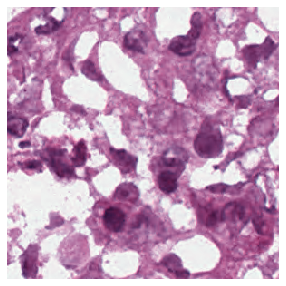

In [53]:
#noexport
if test_example:
    #example = d_sub.iloc[splitter(d_sub)[1]].iloc[4582]
    example = d_sub.iloc[400]
    print(label_double_func(example))
    print(label_triple_func(example))
    print(label_quatr_func(example))
    print(example)
    pati = get_x(example)
    show_image(pati)
        

In [54]:

tissue_stats =  ([0.6365042 , 0.4866035 , 0.66030514],[0.2311546 , 0.27366328, 0.19013868]) #EPICOLON TUM+STR+LYM selected
#tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
#tissue_stats = ([0.6698, 0.5181, 0.6594], [0.2080, 0.2573, 0.1874]) #TCGA svs  
#tissue_stats = ([0.6865583 , 0.5289199 , 0.66556716], [0.20485608, 0.2561432 , 0.18819469]) #TCGA svs TUM+STR+LYM selected
tissue_stats

([0.6365042, 0.4866035, 0.66030514], [0.2311546, 0.27366328, 0.19013868])

In [55]:
_d_sub = d_sub#.sample(frac=.01)


In [56]:
_d_sub.label.value_counts(dropna=False)

2.0    1274057
1.0     294857
Name: label, dtype: int64

In [57]:
#def img2tensor(im: Image.Image): return TensorImage(array(im)[None])
import torchstain
tcga_target = image2tensor(load_image(get_image_files(Path('TCGA/TILES'))[0])) #just pick 1st TCGA
macenko_normalizer = torchstain.MacenkoNormalizer(backend='torch')
macenko_normalizer.fit(tcga_target)

In [58]:

patient_classes = L(sorted(set(_d_sub.patient_ID.unique())))

cristal = None
if 'svs_fn' in _d_sub.columns:
    cristal = np.append(_d_sub.tif_fn.dropna().unique(),_d_sub.svs_fn.dropna().unique())
else:
    cristal = _d_sub.tif_fn.dropna().unique()

print(len(cristal))
TMA_classes = L(sorted(cristal))


tfms = [[get_x],
       [label_func, Categorize(vocab = ['MSS', 'MSI'], sort = False)],
       [label_bias_func, Categorize(vocab = ['Other', 'HGUA', 'TCGA'], sort = False)],
       [label_bias1_func, Categorize(vocab = patient_classes, sort = False)],
       [label_bias2_func, Categorize(vocab = TMA_classes, sort = False)],
       ]
train_ds = Datasets(_d_sub[(_d_sub.valid == 0)  ],tfms,n_inp=1)
valid_ds = Datasets(_d_sub[_d_sub.valid == 1],tfms,n_inp=1)
test_ds = Datasets(_d_sub[_d_sub.valid == 2],tfms,n_inp=1)

535


In [59]:
assert len(set(_d_sub[(_d_sub.valid == 0)  ].patient_ID.unique()) & set(_d_sub[(_d_sub.valid == 2)  ].patient_ID.unique()) & set(_d_sub[(_d_sub.valid == 1)  ].patient_ID.unique())) == 0

In [60]:
#print(sorted(set(_d_sub[(_d_sub.valid == 0)  ].patient_ID.unique())))
#print(sorted(set(_d_sub[(_d_sub.valid == 2)  ].patient_ID.unique())))

In [61]:
#noexport
example = 5
xd,yd, yd1, yd2, yd3 = decode_at(train_ds,example)
xd.shape,yd, yd1, yd2, yd3

(torch.Size([3, 300, 300]), 'MSS', 'Other', '5048', 'TMA06-08')

In [62]:
#noexport
decode_at(train_ds, example)

(TensorImage([[[0.9258, 0.9297, 0.9336,  ..., 0.6133, 0.5977, 0.5703],
          [0.9258, 0.9258, 0.9297,  ..., 0.6211, 0.6055, 0.5781],
          [0.9219, 0.9219, 0.9219,  ..., 0.6602, 0.6250, 0.5820],
          ...,
          [0.4062, 0.4062, 0.4258,  ..., 0.8633, 0.8359, 0.8203],
          [0.4297, 0.4414, 0.4570,  ..., 0.8516, 0.8281, 0.8164],
          [0.4492, 0.4492, 0.4492,  ..., 0.8320, 0.8164, 0.8086]],
 
         [[0.9336, 0.9336, 0.9258,  ..., 0.4453, 0.4375, 0.4141],
          [0.9336, 0.9297, 0.9219,  ..., 0.4570, 0.4492, 0.4258],
          [0.9258, 0.9297, 0.9219,  ..., 0.4922, 0.4492, 0.4062],
          ...,
          [0.2656, 0.2656, 0.2812,  ..., 0.7266, 0.6797, 0.6406],
          [0.2578, 0.2695, 0.2695,  ..., 0.6836, 0.6367, 0.6055],
          [0.2891, 0.2852, 0.2773,  ..., 0.6562, 0.6250, 0.6094]],
 
         [[0.9336, 0.9336, 0.9297,  ..., 0.6328, 0.6250, 0.6055],
          [0.9336, 0.9336, 0.9297,  ..., 0.6406, 0.6328, 0.6133],
          [0.9297, 0.9336, 0.9297, 

In [63]:
#noexport
x,y,y1, y2, y3= train_ds[example]
x.shape,y,y1, y2, y3

(torch.Size([3, 300, 300]),
 TensorCategory(0),
 TensorCategory(0),
 TensorCategory(1094),
 TensorCategory(480))

In [115]:
#noexport
#train_ds

In [68]:
#noexport
#show_at(train_ds, 0)

In [69]:
#noexport
timg = x
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

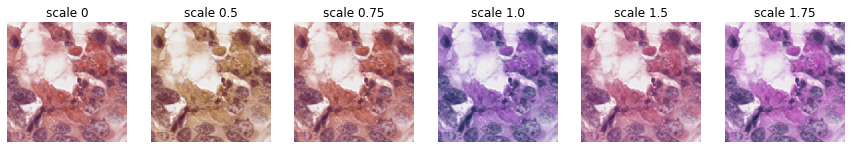

In [70]:
#noexport
scales = [0,0.5, 0.75, 1., 1.5, 1.75]
y = _batch_ex(len(scales)).saturation(max_lighting= 0.4, p=1., )
y = _batch_ex(len(scales)).hue(max_hue= 0.15, p=1., )
fig,axs = plt.subplots(1,len(scales), figsize=(15,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [71]:
bs = 4* a.bs * torch.cuda.device_count()
print(f'batch size= {bs}')
#aug = aug_transforms(mult=2, flip_vert=True, max_rotate=90., min_zoom=0.5, max_zoom=5, size = 224)
aug = aug_transforms(mult=1, do_flip=False,flip_vert=False, max_rotate=0., min_zoom=1, max_zoom=1, size = 224,
                 max_lighting=0,p_lighting=0, 
                    xtra_tfms=[Saturation(max_lighting=0.4,p=1), Hue(max_hue = 0.2, p= 1)])
wgts = _d_sub[_d_sub.valid == 0].weights.values

batch size= 640


In [72]:
calculate_stats = False
if calculate_stats:
    train_dl = WeightedDL(train_ds,shuffle=True,bs=5000, device=default_device(),
                     wgts=wgts,)
    valid_dl = WeightedDL(valid_ds,wgts=None,bs=2500)
    dls = DataLoaders(train_dl, valid_dl, device=default_device(), )
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats)

    

In [73]:


train_dl = WeightedDL(train_ds,shuffle=True,bs=bs, num_workers=a.j, 
                      after_batch=[Normalize.from_stats(*tissue_stats), *aug,],
                     device=default_device(),
                     wgts=wgts,
                     )
valid_dl = TfmdDL(valid_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)], )
test_dl  = TfmdDL(test_ds,bs=bs//4, num_workers=max(1,a.j//4),after_batch=[Normalize.from_stats(*tissue_stats)],)

In [74]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device(), )

In [114]:
#noexport
#dls.train.dataset

In [113]:
#noexport
#dls.train.one_batch()

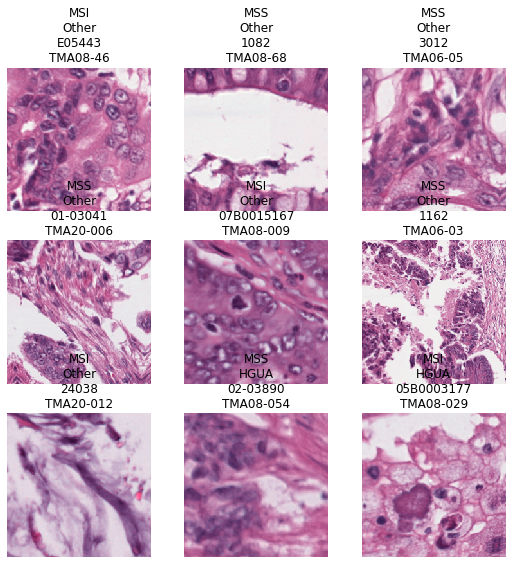

In [77]:
#noexport
dls.show_batch()

In [116]:
#noexport
#dls.vocab

In [117]:
#noexport
#print (dls[0].tfms)
#print (dls[0].after_batch)
#bx=dls.one_batch()[0]
#print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
#aug

# Model

In [120]:
#noexport
print([f.name for f in Path('models/no_mazenko/models').ls()]) #trained k-Folds models

['old_models', "Do_not_remove_0_MSI_classifier_TissueBackbone_Corr_Loss_toy_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1]_start=0.0_period=1_maxepochs=50_AUC=0.9788688832431237.pth", "Do_not_remove_0_MSI_classifier_TissueBackbone_Corr_Loss_toy_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=50_AUC=0.9836628741853529.pth", "Do_not_remove_0_MSI_classifier_TissueBackbone_Corr_Loss_toy_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1]_start=0.0_period=1_maxepochs=50_AUC=0.9344747597481498.pth", "Do_not_remove_0_MSI_classifier_TissueBackbone_Corr_Loss_toy_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1]_start=0.0_period=1_maxepochs=50_AUC=0.975057991825914.pth", "0_MSI_classifier_TissueBackbone_Corr_Loss_epicolon_only_HGUA_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=50_AUC=0.8505434782608695.pth", "0_MSI_classifier_TissueBackbone_Corr_Loss_epicolon_only_HGUA_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[2, 3]_

In [81]:
b = dls[0].one_batch()

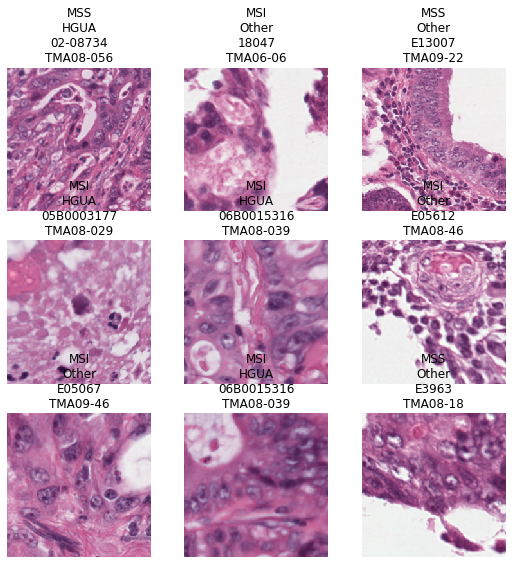

In [82]:
#noexport
dls.show_batch(b)

In [83]:
learn_pretrained = cnn_learner(dls, resnet34, metrics=[RocAuc()],normalize=False, n_out=9,
                                 path=Path("."), pretrained=False, loss_func=CrossEntropyLossFlat())

#learn_pretrained = cnn_learner(dls, vgg16, metrics=[RocAuc()],normalize=False, n_out=9,
                                  #path=Path("."), pretrained=True, loss_func=CrossEntropyLossFlat())

tissue_model = 'pretrained_tissue_aug_BAC_epicolon0.9993681800971788'

learn_pretrained.load(tissue_model)
m_tissue_classifier =  learn_pretrained.model


    


In [ ]:
#noexport
if test_example: #visually check tissue type classification in loaded dataset (TODO: check odd behaviour as all the samples were previously selected as TUM)
    #x = torch.randn(2,3,300,300)
    bx = b[0]
    _preds = m_tissue_classifier(bx.cpu())
    #print(preds)
    preds = torch.argmax(nn.Softmax(dim=-1)(_preds), dim = -1)
    #print(preds)
    classes = [cls[i] for i in preds]
    print(classes[:9])
    print(preds)

In [85]:
class DropBiasInXY(Callback):
    run_train = False
    def after_pred(self):
        if isinstance(self.learn.pred,tuple) and len(self.learn.pred)>1:
            self.learn.pred = self.learn.pred[0],self.learn.pred[1] 
        if isinstance(self.learn.yb,tuple) and len(self.learn.yb)>1:
            self.learn.yb   = (self.learn.yb[0],)
            

#noexport
learn_pretrained.metrics = []
res = learn_pretrained.get_preds(cbs=[DropBiasInXY()])

#noexport
res[0][:10]

In [86]:
mk_class('ActivationType', **{o:o.lower() for o in ['No', 'Sigmoid', 'Softmax', 'BinarySoftmax']},
         doc="All possible activation classes for `AccumMetric")

@patch
def accumulate(self:AccumMetric, learn):
    "Store targs and preds from `learn`, using activation function and argmax as appropriate"
    pred = learn.pred[0] #ignore features...
    if self.activation in [ActivationType.Softmax, ActivationType.BinarySoftmax]:
        pred = F.softmax(pred, dim=self.dim_argmax)
        if self.activation == ActivationType.BinarySoftmax: pred = pred[:, -1]
    elif self.activation == ActivationType.Sigmoid: pred = torch.sigmoid(pred)
    elif self.dim_argmax: pred = pred.argmax(dim=self.dim_argmax)
    if self.thresh:  pred = (pred >= self.thresh)
    self.accum_values(pred,learn.y[0],learn)


@patch
def __accum_values(self:AccumMetric, preds, targs,learn=None):
    "Store targs and preds"
    to_d = learn.to_detach if learn is not None else to_detach
    print(preds,targs)
    preds,targs = to_d(preds[0]),to_d(targs)
    print(preds,targs)
    keep = targs != -100
    preds,targs = preds[keep],targs[keep]
    if preds.numel() == 0: return
    if self.flatten: preds,targs = flatten_check(preds,targs)
    self.preds.append(preds)
    self.targs.append(targs)
    

In [87]:
from fastai.fp16_utils import convert_network
class PutYinX(Callback):
    def __init__(self,m_tissue_classifier): 
        self.tissue_classifier = m_tissue_classifier
        self.tissue_classifier.eval().cuda()
    def before_batch(self):
        #self.learn.xb = self.learn.xb[0],self.learn.xb[1], self.learn.xb[1]
        pass
    def after_pred(self):
        if self.learn.y is None: return
        with torch.no_grad():
            tissue_class = convert_network(self.tissue_classifier,x.dtype)(self.x)
        tissue_class = torch.argmax(nn.Softmax(dim=1)(tissue_class), dim = 1)
        def change(t,cond):
            t[cond]=-100
            return t
        self.learn.yb = apply(partial(change,cond=tissue_class <= 1 ),self.learn.yb)

In [88]:

class TissueBackbone(Module ):
    def __init__(self, m_tissue_classifier ):
        
        self.force_msi = False
        #self.force_fe = False
        
        self.feature_extractor = nn.Sequential( # feature extractor
            nn.ModuleList(m_tissue_classifier.children())[0],
            AdaptiveConcatPool2d(1),
            Flatten(full=False),             
            ).cuda()
        
        self.msi_classifier = nn.Sequential(
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        self.bias_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        self.bias1_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2400, bias=False)).cuda()
        
        self.bias2_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=550, bias=False)).cuda()
    
    def forward(self, x, _forward=None):
        if _forward is not None: return getattr(self,_forward)(x)
        
        fe = self.feature_extractor(x)
        pred_msi = self.msi_classifier(fe)
        if self.force_msi: return pred_msi
        pred_bias = self.bias_classifier(fe)
        pred_bias1 = self.bias1_classifier(fe)
        pred_bias2 = self.bias2_classifier(fe)
        
        #if self.force_fe: return fe
        #if self.force_msi or not self.train: return pred_msi
        
        return (pred_msi, fe, pred_bias, pred_bias1, pred_bias2)


In [89]:

# adversial loss for squared correlation 
def correlation_coefficient_loss0(y_pred, y_true):
    num_classes = y_pred.shape[-1]
    keep = y_true != -100
    x,y = y_pred[keep],y_true[keep]
    
    
    y = torch.nn.functional.one_hot(y, num_classes = num_classes)
    y = y.float()
    x = x.float()
    
    y = F.softmax(y, dim=-1)
    x = F.softmax(x, dim=-1)
    
    y = y.flatten()
    x = x.flatten()
   
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    
    return r**2

In [90]:
# adversial loss for squared correlation 
def correlation_coefficient_loss1(y_pred, y_true):
    num_classes = y_pred.shape[-1]
    
    keep = y_true != -100
    x,y = y_pred[keep],y_true[keep]
    
    
    y = torch.nn.functional.one_hot(y, num_classes = num_classes)
    y = y.float()
    x = x.float()
    
    y = F.softmax(y, dim=-1)
    x = F.softmax(x, dim=-1)
    
    y = y.flatten()
    x = x.flatten()
    
    
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    r = cos(x - x.mean(dim=0, keepdim=True), y - y.mean(dim=0, keepdim=True))
    
    r = r**2
    
    
    return r

In [91]:
# adversial loss for squared correlation 
def correlation_coefficient_loss(y_pred, y_true):
    y = y_true.float()
    x = y_pred.float()
    x = F.softmax(x, dim=-1)
    x = x[:,-1].squeeze() #only correct for two classes
    
    
    keep = y != -100
    x,y = x[keep],y[keep]
    #print(x)
    #print(x.shape)
    #print(y.shape)
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    return r**2

In [92]:
y_true = torch.tensor([1, 0, -100, 0])
y_true = torch.tensor([0, 1, -100, 1])
y_true = torch.tensor([0, 1, -100, 1])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])

y_true = torch.tensor([0, 0, 0, 0])
y_pred = torch.tensor([[5, -2], [5, -2], [5, -2], [5, -2]])

y_true = torch.tensor([-100, 0, 0, 2])
#y_true = torch.tensor([0, 0, 0, 0])
y_pred = torch.tensor([[0, 1,0], [0, 0,1], [1, 0,0], [0, 0,1]])


y_true = torch.tensor([1, 0, -100, 0])
#y_true = torch.tensor([0, 1, -100, 1])
#y_true = torch.tensor([[0,1], [1,0], [-100,-100], [1,0]]) multiclass
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])



In [93]:
#noexport

y_true = torch.tensor([1, 0, -100, 0])
y_true = torch.tensor([0, 1, -100, 1])
y_true = torch.tensor([0, 1, -100, 1])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])

print(y_true)
print(f'original: {correlation_coefficient_loss(y_pred, y_true)}, mod_original:  {correlation_coefficient_loss0(y_pred, y_true)},  cos: {correlation_coefficient_loss1(y_pred, y_true)}')

ce = nn.CrossEntropyLoss()
print(f'crossentropy: {ce(y_pred.float(), y_true)}')



tensor([   0,    1, -100,    1])
original: 0.9969836473464966, mod_original:  0.9970629215240479,  cos: 0.9999696016311646
crossentropy: 0.0047807046212255955


In [94]:
#bias-extracted features correlation function
def feat_target_corr(f, t):
    feat = torch.flatten(f, start_dim=1)
    feat = np.array(feat.cpu())
    targ = np.array(t.cpu())
    dc = dcor.u_distance_correlation_sqr(feat,targ)
    
    return dc

In [95]:

correlations = []
losses = []

from torch.autograd import Variable
@patch
def _do_one_batch(self:Learner):
    
    features = None
    lambda_coef = 1. if len(a.control_bias) == 0 else a.lambda_coef
    iteration = self.iter + (self.epoch * self.n_iter )
    
    for child in self.model.children():
        for param in child.parameters(): 
            param.requires_grad = True
    
    self.pred = self.model(*self.xb);                self('after_pred')
    bias_pred = self.pred[2] #self.model(self.pred[1].type_as(self.xb[0]),_forward='bias_classifier')
    
    if len(self.yb) == 0: return
    if not self.training: 
        self.loss = lambda_coef * self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
        return
    else:
        self.loss = lambda_coef * self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
        
    losses.append([iteration,self.loss.item(), 'target_loss'])
      
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    
    if a.verbose:
        features = self.pred[1].detach()
        corrs = []
        for bias in self.yb: corrs.append(feat_target_corr(features, bias))
        print(f'finished 1º training step: MSI-Pred-loss {self.loss}, corrs: {corrs}')
        corrs.insert( 0, iteration)
        correlations.append([corrs])
        #------------- record bias loss ------#
        
        bias_loss = 1 - correlation_coefficient_loss(bias_pred, self.yb[1])
        losses.append([iteration,bias_loss.item(), 'bias1_loss'])
        #------------------------------------#
        
        
    if ((a.distillation_start /100) * self.n_iter > self.iter * (self.epoch + 1)) : return
    
    model = getattr(self.model, 'module', self.model)
    
    #---------------------------------------------------------------------#
    if (1 in a.control_bias): 
        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSS status: select only one class (MSI +) as it represents evenly both HGUA and Others samples on this dls  
        cond_target = self.yb[1] #In Hospital target --> 
        cond_target[self.yb[0] == 0] = -100 #ablate MSS samples (coded 0)
        if True:
                        
            for child in model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = False
            #features = self.model.feature_extractor(*self.xb)    
            features = self.model(*self.xb,_forward='feature_extractor')    

            for child in model.bias_classifier.children():
                for param in child.parameters(): param.requires_grad = True

            #self.pred = self.model.bias_classifier(features);                self('after_pred')
            self.pred = self.model(features,_forward='bias_classifier');                self('after_pred')
            #if len(self.yb[1]) == 0: return

            #self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
            self.loss = 1 - correlation_coefficient_loss(self.pred, cond_target); self('after_loss')

            losses.append([iteration,self.loss.item(), 'bias1_loss'])

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 2º training step: Bias-Pred {self.loss}')  
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            for child in model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = True
            for child in model.bias_classifier.children():
                for param in child.parameters(): param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[1]) == 0: return

            #self.loss = lambda_coef * correlation_coefficient_loss1(self.pred[1], cond_target); self('after_loss') tontainas
            self.loss =  lambda_coef * correlation_coefficient_loss(self.pred[2], cond_target); self('after_loss')
            
            if not self.training: return
            

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 3º training step: Bias-Distillator {self.loss}')
        #---------------------------------------------------------------------#    
    
    if (2 in a.control_bias):
        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSS )   
        cond_target = self.yb[2] #Bias1  
        cond_target[self.yb[0] == 1] = -100 #ablate MSI samples (coded 1)
        if True:
            for child in model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = False
            #features = self.model.feature_extractor(*self.xb)    
            features = self.model(*self.xb,_forward='feature_extractor')    

            for child in model.bias1_classifier.children():
                for param in child.parameters(): param.requires_grad = True

            self.pred = self.model(features,_forward='bias1_classifier');                self('after_pred')
            if len(self.yb[2]) == 0: return

            #self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
            self.loss = 1 - correlation_coefficient_loss1(self.pred, cond_target); self('after_loss')
            losses.append([iteration,self.loss.item(),  'bias2_loss'])

            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 4º training step: Bias1-Pred {self.loss}')            
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            for child in model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = True
            for child in model.bias1_classifier.children():
                for param in child.parameters(): param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[2]) == 0: return

            self.loss = lambda_coef * correlation_coefficient_loss1(self.pred[3], cond_target); self('after_loss')
            #self.loss = - self.loss_func(self.pred[2].float(), cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 5º training step: Bias1-Distillator {self.loss}')
          #---------------------------------------------------------------------#    
    
    if (3 in a.control_bias):
        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSS )   
        cond_target = self.yb[3] #Bias2 
        abl = 0 if a.ablate == 'MSS' else 1
        cond_target[self.yb[0] == abl ] = -100 #ablate MSS samples (coded 0)

        if True:
            for child in model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = False
            #features = self.model.feature_extractor(*self.xb)    
            features = self.model(*self.xb,_forward='feature_extractor')    

            for child in model.bias2_classifier.children():
                for param in child.parameters(): param.requires_grad = True

            self.pred = self.model(features,_forward='bias2_classifier');                self('after_pred')
            if len(self.yb[3]) == 0: return

            
            self.loss = 1 - correlation_coefficient_loss1(self.pred, cond_target); self('after_loss')
            losses.append([iteration,self.loss.item(),  'bias3_loss'])

            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 6º training step: Bias2-Pred {self.loss}')            
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            for child in model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = True
            for child in model.bias2_classifier.children():
                for param in child.parameters(): param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[3]) == 0: return

            lambda_coef = 1
            self.loss = lambda_coef * correlation_coefficient_loss1(self.pred[4], cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 7º training step: Bias2-Distillator {self.loss}')
        #---------------------------------------------------------------------#    



In [96]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ[0])
    return (pred == targ).float().mean()

fastai.metrics.accuracy = accuracy

In [97]:
learn_path = Path('models/no_mazenko')
#learn_path = Path('.')

In [98]:
tissue_backbone = True
if tissue_backbone: 
    x = torch.randn(2, 3, 300, 300).cuda()
    m = TissueBackbone(m_tissue_classifier)
    y = m(x)
    
    
    learn = Learner(dls, m, path= learn_path, metrics=[RocAucBinary()], loss_func = CrossEntropyLossFlat(),
                    #cbs=[PutYinX(m_tissue_classifier),DropBiasInXY()])# cbs = CutMix(alpha=1.))
                    cbs = [SaveModelCallback(monitor='roc_auc_score',fname=f'model_fold{a.fold}')])
                    
                   #)#,  

else: 
    learn = cnn_learner(arch=resnet34, #loss_func = CrossEntropyLossFlat,
                dls = dls, metrics=[error_rate, RocAucBinary()
                                   ], normalize=False, cbs=[PutYinX(m_tissue_classifier)])

In [99]:
#noexport
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epo

In [100]:
if a.local_rank is not None: 
    
    learn.to_distributed(a.local_rank)    
    
elif n_gpus > 1:
    learn.to_parallel()
    a.lr *= n_gpus
    for dl in learn.dls: dl.bs = n_gpus * a.bs 
    pass

In [101]:
f_fp16 = getattr(learn,a.fp16,None)
if f_fp16: f_fp16()

In [102]:
#learn.to_parallel()

In [103]:
#learn.dls[0].one_batch()

In [104]:
#learn.validate()



In [105]:
#learn.summary()


In [106]:
if not a.test_saved_model:
    #learn.fit_one_cycle(a.epochs,a.lr)
    learn.fit(a.epochs,a.lr)
    
    #learn.fit(10,a.lr)


In [ ]:
model_name = a.test_saved_model
if not a.test_saved_model:
    #learn.fine_tune(20)
    auc_val = learn.final_record[2]
    print(learn.final_record)
    #auc_val = 0.813439
    zf = ifnone(a.zoom_filter,'01234')
    bias = 'No' if len(a.control_bias) == 0 else a.control_bias
    if bias != 'No':
        model_name = f'{a.fold}_MSI_classifier_TissueBackbone_Corr_Loss_{a.dataset}_zoom={zf}_{a.tissues}__BiasDistilled={bias}_ablate={a.ablate}_start={a.distillation_start/100}_period={a.distillation_period}_maxepochs={a.epochs}_AUC={auc_val}'
    else: 
        model_name = f'{a.fold}_MSI_classifier_TissueBackbone_Corr_Loss_{a.dataset}_zoom={zf}_{a.tissues}__BiasDistilled={bias}_start={a.distillation_start/100}_period={a.distillation_period}_maxepochs={a.epochs}_AUC={auc_val}'
    print(model_name)
    learn.save(model_name )
else:
    #learn.load(f'MSI_classifier_TissueBackbone_epicolon_cb_level_None_0.8720548604657441')
    #learn.load('MSI_classifier_TissueBackbone_epicolon_BiasDistilled_level_None_TUM_0.8762951242193902')
    #learn.load('MSI_classifier_TissueBackbone_Corr_Loss_epicolon_BiasDistilled_level_None_TUM_0.8848650115631501')
    learn.load(a.test_saved_model)
    print(f'succesfully loaded {a.test_saved_model} for testing')

In [108]:
if not a.test_saved_model:
    metrics = np.array(correlations).reshape(-1,5)
    metrics_df = pd.DataFrame(metrics, columns = ['Iteration', 'FE-MSI dc', 'FE-Bias1 dc', 'FE-Bias2 dc','FE-Bias3 dc'])
    metrics_df = metrics_df.astype({'Iteration': 'int32'})
    metrics_df.index = metrics_df.Iteration
    metrics_df.drop(columns = ['Iteration'], inplace = True)
    metrics_df.to_csv(model_name)

In [109]:
if not a.test_saved_model:
    plot = sns.lineplot(data=metrics_df)
    plot.figure.savefig(f'graphs/dcorr_batch_{model_name}.png',  bbox_inches='tight')

In [110]:
if not a.test_saved_model:
    loss_df = pd.DataFrame(losses, columns = ['Iteration', 'Loss', 'Task'] )
    loss_df.to_csv(model_name)

In [111]:
if not a.test_saved_model:
    plot = sns.lineplot('Iteration', 'Loss', hue = 'Task', data=loss_df[0:10000])
    plot.figure.savefig(f'graphs/losses_batch_{model_name}.png',  bbox_inches='tight')

In [112]:

#learn.validate()

In [113]:
#learn.show_results()

In [114]:
#interp = Interpretation.from_learner(learn)

In [115]:
#interp.plot_top_losses(50, figsize=(30,30))

### Label spot wiht sliding tiles

In [116]:
if a.pred_patient_img:
    import matplotlib
    #matplotlib.use('Agg') #comment to show images in notebook
    import matplotlib.pyplot as plt



    ds_f = _d_sub.loc[(_d_sub.valid == 1)]


    #ds_f = _d_sub.loc[(_d_sub.spot_ID == '7123')]
    #print(ds_f.valid.mean())


    for spot in ds_f.groupby(['spot_coord','tif_fn'] ):

        spot_coord, tif_fn = spot[0]
        labels = ['Missing', 'MSI', 'MSS']
        img_label = f'{tif_fn}_{spot_coord}_{spot[1].iloc[0].spot_ID}_Label_{labels[int(spot[1].iloc[0].label)]}.png'
        print(img_label)
        spot[1].reset_index(inplace = True)
        sample_spot = learn.dls.test_dl(spot[1] )
        bx=learn.dls.one_batch()[0] #.mean(dim=[0,2,3])
        #print(f'min, max, mean for RGB colors: {bx.min()},{bx.max()},{bx.mean(dim=[0,2,3])}')

        #predict
        imgs, probs, classes, clas_idx = learn.get_preds(dl=sample_spot, with_input=True, with_decoded=True)
        print(f'N of voting tiles: {probs.shape[0]}')

        MSI_score = np.mean(probs.cpu().numpy()[:,1])
        print (f'MSI-score= {MSI_score}')

        ds_spot_4.loc[(ds_spot_4.tif_fn == tif_fn) & (ds_spot_4.spot_coord ==spot_coord) , 'pred_MSI_score_x20'] = MSI_score


        #try:
        #create mask
        size_spot = (300,300) #should match tile size for level 4
        # translate pixel level 0 to mask pixel
        spot_4 = ds_spot_4.loc[(ds_spot_4.spot_coord == spot_coord)&(ds_spot_4.tif_fn == tif_fn)]
        pix_up_left_x = spot_4.iloc[0].tile[0]
        pix_up_left_y = spot_4.iloc[0].tile[1]


        size =  (300,300)
        level = spot[1].iloc[0].tile[3]
        zoom_out = 2**4 #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 4 (spot enclosed in 300 x 300 pixel image)
        zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
        tile_mask_side_length = size[0] / zoom_out_tile

        print(f'Each sliding tile will cover in the mask a square of side {tile_mask_side_length} pixels' )
        print(f'Pixel absolute coordinates in original TMA (upper-left and lower-right corners)')
        print(pix_up_left_x, pix_up_left_y)
        print(spot_4.iloc[0].tile[0] + size_spot[0]* 2**4, spot_4.iloc[0].tile[1] + size_spot[0]* 2**4)
        print(f'Upper left square represents the prediction of tile at level 4')

        #---------------------------------------------
        matrix_prob = pd.DataFrame( columns = np.arange(size_spot[0]), index = np.arange(size_spot[0]))
        matrix_prob = matrix_prob.fillna('np.nan(),')


        for i, row in spot[1].iterrows():

            x,y= (row.tile[0] - pix_up_left_x) / zoom_out, (row.tile[1] - pix_up_left_y) / zoom_out

            zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
            tile_mask_side_length = size[0] / zoom_out_tile

            matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length) 
                     ] =  matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length)
                                     ] + str(probs[i][1].cpu().numpy()) + ','




        def f_prob(s):
            result = 0.5 #default (for 0.5) is undecided color in a two-color spectrum
            try:
                p = s.split(',')
                p = list(filter(lambda x: x != '', p))
                if len(p) > 1: 
                    p = p[1:]
                    #p = np.array([float(pro) if (float(pro) < 0.4 or float(pro) > 0.6) else np.nan() for pro in p ])
                    p = np.array([float(pro) for pro in p ])

                    result = np.nanmean(p)

                else:
                    result = float(s)
            except: 
                pass
            return result

        matrix_prob = matrix_prob.applymap(f_prob)
        img_prob = matrix_prob.values






        show_plot = True 
        if show_plot: 
            plt.figure()
            fig, axs = plt.subplots(1, 2, figsize=(30, 15))

            #im1 = axs[1].imshow(get_x(spot_4.iloc[0]), interpolation='nearest')


            im = axs[0].imshow(img_prob, interpolation='nearest', cmap='seismic', vmin=0., vmax=1)
            axs[0].set_title("Mask_MSI_probs")
            cbar = fig.colorbar(im, ax=axs[0], ticks= np.arange(2), fraction = 0.02)
            cbar.ax.set_yticklabels(['MSS','MSI']) 


            show_image(get_x(spot_4.iloc[0]), ax = axs[1], title = spot_4.iloc[0].tile)


            plt.show() 
            plt.close()
            #plt.savefig(img_label)
        #except:
        print('------------------'+ '\n')


#### Study correlations between extracted features and bias 

In [117]:

hospital = [0,1]
partition = 0

In [118]:
reduced_ds = Datasets(_d_sub[(_d_sub.valid == partition) & (_d_sub.hospital.isin(hospital))   ].sample(frac = 0.01, random_state = 123) ,tfms,n_inp=1)


train_reduced_dl = WeightedDL(reduced_ds,shuffle=False,bs=bs, num_workers=a.j, 
                      after_batch=[Normalize.from_stats(*tissue_stats), *aug,],
                     device=default_device(),
                     wgts=wgts,
                     )
#valid_dl = TfmdDL(valid_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)], )
#test_dl  = TfmdDL(test_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)],)

dls_reduced = DataLoaders(train_reduced_dl,  device=default_device(), )
#preds, targs = learn.get_preds(dl=dls[2], with_input=False, with_loss=False, with_decoded=False, act=None, cbs=[])
preds, targs = learn.get_preds(dl=dls_reduced[0],act=noop )


In [119]:
n = len(preds[0])
#idxs = np.random.choice(n//2,n,replace=False)
out = preds[1][:n]
out.shape

torch.Size([4232, 1024])

In [123]:
Z_targ = np.array(targs[0].cpu())
Z_bias = np.array(targs[1].cpu())
criteria = Z_targ == 0
#criteria = np.ones_like(Z_targ,dtype=bool)

In [124]:
cm = feat_target_corr(out.detach()[criteria],targs[0][criteria])
ch = feat_target_corr(out.detach()[criteria],targs[1][criteria])
cp = feat_target_corr(out.detach()[criteria],targs[2][criteria])
ct = feat_target_corr(out.detach()[criteria],targs[3][criteria])
print(f'corr with msi, hospital, patient, TMA: {cm},{ch},{cp},{ct}')

corr with msi, hospital, patient, TMA: 0.0,0.1898991340538851,0.08751055294188467,0.07353585695343315


In [122]:
import os


filename = 'results_log/feat_targ_corr.tsv'

if os.path.exists(filename):
    append_write = 'a' # append if already exists
    f = open(filename,append_write)
    f.write(f'{model_name} {hospital}\t{cm}\t{ch}\t{cp}\t{ct}\n')
else:
    append_write = 'w' # make a new file if not
    f = open(filename,append_write)
    f.write(f'model_hospital\tmsi\thospital\tpatient\tglass\n')
    f.write(f'{model_name} {hospital}\t{cm}\t{ch}\t{cp}\t{ct}\n')
f.close()

In [108]:
#noexport
dff = pd.read_csv('results_log/feat_targ_corr.tsv', sep = '\t')
dff.loc[(dff.msi == 0) & (dff.model_hospital.str.contains('BiasDistilled=[1, 2, 3]', regex=False)) ].describe()

msi   hospital    patient      glass
count  20.0  20.000000  20.000000  20.000000
mean    0.0   0.104098   0.048521   0.037246
std     0.0   0.047086   0.018755   0.013232
min     0.0   0.040031   0.021738   0.020604
25%     0.0   0.064166   0.033645   0.025715
50%     0.0   0.098970   0.046255   0.034563
75%     0.0   0.129834   0.062065   0.049137
max     0.0   0.208018   0.086314   0.065220

In [109]:
#noexport
dff.loc[(dff.msi == 0) & (dff.model_hospital.str.contains('BiasDistilled=No', regex=False)) ].describe()

msi   hospital    patient      glass
count  11.0  11.000000  11.000000  11.000000
mean    0.0   0.257056   0.120265   0.078708
std     0.0   0.057294   0.028661   0.008662
min     0.0   0.189899   0.087511   0.069591
25%     0.0   0.212069   0.095559   0.072391
50%     0.0   0.237926   0.107999   0.076623
75%     0.0   0.308320   0.140350   0.083267
max     0.0   0.341994   0.164245   0.096740

In [111]:
#noexport
dff.loc[(dff.msi != 0) & (dff.model_hospital.str.contains('BiasDistilled=No', regex=False)) ]

model_hospital  \
3  0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=3_AUC=0.8840031751729733 [0, 1]   
4     0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=3_AUC=0.8840031751729733 [0]   
5    0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=No_start=0.0_period=1_maxepochs=3_AUC=0.8840031751729733 [1]    

        msi  hospital   patient     glass  
3  0.089797   0.17723  0.086632  0.076801  
4  0.047064   0.00000  0.028432  0.074765  
5  0.460635   0.00000  0.296931  0.293851

In [112]:
#noexport
dff.loc[(dff.msi != 0) & (dff.model_hospital.str.contains('BiasDistilled=[', regex=False)) ]

model_hospital  \
0  0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1, 2, 3]_start=0.0_period=1_maxepochs=3_AUC=0.8815228236064272 [0, 1]   
1     0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1, 2, 3]_start=0.0_period=1_maxepochs=3_AUC=0.8815228236064272 [0]   
2    0_MSI_classifier_TissueBackbone_Corr_Loss_['epicolon_only_HGUA', 'epicolon_other']_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1, 2, 3]_start=0.0_period=1_maxepochs=3_AUC=0.8815228236064272 [1]    

        msi  hospital   patient     glass  
0  0.212269   0.02937  0.021070  0.026811  
1  0.158762   0.00000  0.010841  0.015146  
2  0.622148   0.00000  0.359373  0.337338

In [125]:
bias_code = ['MSI-H', 'project', 'patient', 'TMA_glass']
b = 'TMA_glass'

In [126]:
n = len(preds[0])
#idxs = np.random.choice(n//2,n,replace=False)
out = preds[1][:n]
out.shape

torch.Size([4232, 1024])

In [127]:
pca = PCA(n_components=2, whiten=True)
acts_PCA = pca.fit_transform(out)

acts_PCA.shape

(4232, 2)

In [128]:
pca.explained_variance_ratio_.sum()

0.24040082998898965

In [129]:
#remove img where bias = target (criteria)
criteria = Z_bias != Z_targ
#criteria = Z_bias == Z_targ
#criteria = Z_targ == 1
criteria = np.ones_like(Z_bias,dtype=bool)
bias = Z_bias[criteria]
targ = Z_targ[criteria]
pca = acts_PCA[criteria]
print(len(bias))

4232


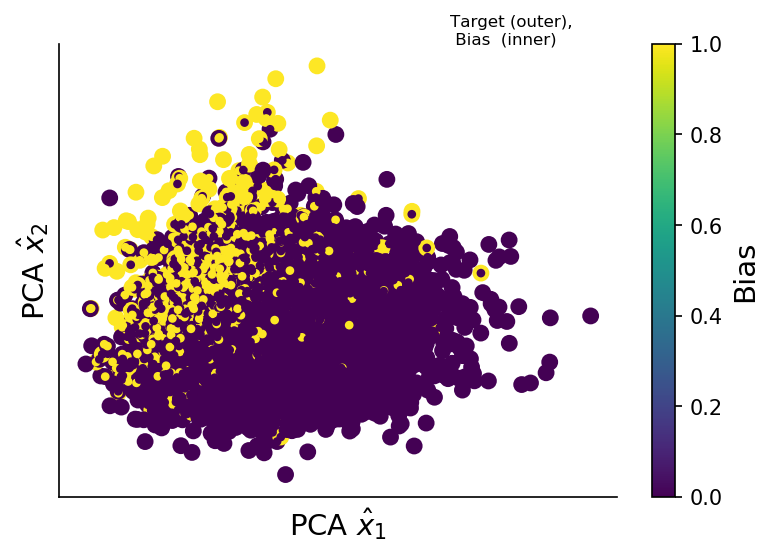

In [130]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)


ax.scatter(pca[:, 0], pca[:, 1], s=50, c=targ ,vmin = 0, vmax = 1 )
sc = ax.scatter(pca[:, 0], pca[:, 1], s=10,  c=bias, )

ax.text(0.7, 1, f'Target (outer),\n Bias  (inner)', transform=plt.gca().transAxes, fontsize=8)

cb = fig.colorbar(sc)
cb.set_label(r'Bias', fontsize=14)



ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=14)
ax.set_ylabel(r'PCA $\hat{x}_2$', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


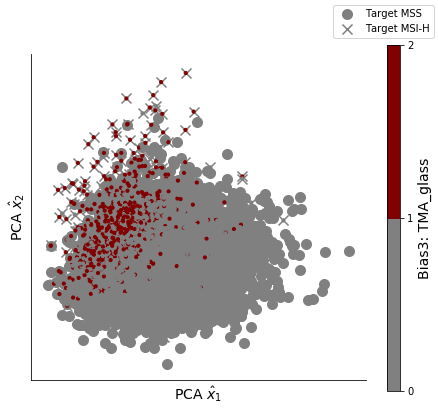

In [131]:

#--------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
uniques = np.unique(bias)
bounds = np.linspace(0, len(uniques) -1 , len(uniques)  )

if len(bounds) == 2: 
    bounds = [0,1,2]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


bias_recoded = [np.where(np.array(sorted(uniques)) == x)[0][0] for x in bias]


# make the scatter
ax.scatter(pca[targ == 0, 0], pca[targ == 0, 1], marker='o', s = 100, c= 'grey', label="Target MSS" )
ax.scatter(pca[targ == 1, 0], pca[targ == 1, 1], marker='x', s = 100, c= 'grey', label="Target MSI-H")

sc = ax.scatter(pca[:, 0], pca[:, 1], c=bias_recoded, s=10,
                  cmap=cmap, norm=norm)




ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=14)
ax.set_ylabel(r'PCA $\hat{x}_2$', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')


fig.legend()

#cb = fig.colorbar(sc)
cb.set_label(f'Bias{bias_code.index(b)}: {b}', fontsize=14)

fig.savefig(f'graphs/pca_fe_{b}_hosp{hospital}_{model_name}.png',  bbox_inches='tight')

# Results Interpretation 

In [134]:
partition = 1 #0,1,2
hospital = [0,1]
criteria = (_d_sub.hospital.isin(hospital)) & (_d_sub.valid == partition) 
#criteria =  (_d_sub.valid == partition) 

#_d_sub[criteria].patient_ID.unique(), _d_sub[(_d_sub.patient_ID.str.contains('-')) & (_d_sub.spot_ID.str.contains('B'))].patient_ID.unique()

In [135]:
c = _d_sub[criteria].sample(frac = 1, random_state = 123).reset_index(drop = True)
c.shape


(1005, 21)

In [136]:
filtered_ds = Datasets(c ,tfms,n_inp=1)
filtered_dl  = TfmdDL(filtered_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)],)

dls_filtered = DataLoaders(filtered_dl,  device=default_device(), )

In [137]:


#preds, targs, decoded, losses = learn.get_preds(dl=dls[partition], with_input=False,
preds, targs, decoded, losses = learn.get_preds(dl=dls_filtered[0], with_input=False,
                                                with_loss=True, with_decoded=True, 
                                                act=lambda x: torch.softmax(x[0].float(),dim=-1))


In [138]:
#noexport
#bt = dls[partition].dataset
bt = filtered_ds

In [139]:
errors_F_neg = np.array(targs[0] - decoded) > 0
F_neg = [i for i, x in enumerate(errors_F_neg) if x]


errors_F_pos = np.array(targs[0] - decoded) < 0
F_pos = [i for i, x in enumerate(errors_F_pos) if x]


def f_neg(x):
    x = F_neg[x]
    print(x,d_sub.loc[d_sub.valid == partition].reset_index().iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[0][x]]}, Predicted {lab[decoded[x]]}'

def f_pos(x):
    x = F_pos[x]
    print(x,d_sub.loc[d_sub.valid == partition].reset_index().iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[0][x]]}, Predicted {lab[decoded[x]]}'

print(f'ERRORS  F+: {len(F_pos)}, F-: {len(F_neg)}')
print(d_sub.loc[d_sub.valid == partition].reset_index().iloc[F_pos].clas_idx.value_counts() * 100 / d_sub.loc[d_sub.valid == partition].clas_idx.value_counts())
print(d_sub.loc[d_sub.valid == partition].reset_index().iloc[F_neg].clas_idx.value_counts() * 100 / d_sub.loc[d_sub.valid == partition].clas_idx.value_counts())

ERRORS  F+: 111, F-: 21
TUM    0.112597
LYM    0.059032
MUC    0.097466
Name: clas_idx, dtype: float64
LYM         NaN
MUC         NaN
TUM    0.022099
Name: clas_idx, dtype: float64


In [140]:
#noexport
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



interact(f_neg, x=2);

interactive(children=(IntSlider(value=2, description='x', max=6, min=-2), Output()), _dom_classes=('widget-int…

In [141]:
#noexport
interact(f_pos, x=2);

interactive(children=(IntSlider(value=2, description='x', max=6, min=-2), Output()), _dom_classes=('widget-int…

In [142]:
preds_val = preds.float().softmax(dim=-1).cpu()[...,-1]
print(f' N Preds: {preds_val.shape}')


 N Preds: torch.Size([1005])


In [143]:
#noexport
decoded, targs, losses, preds

(tensor([0, 0, 0,  ..., 0, 0, 0]),
 (TensorCategory([0, 0, 0,  ..., 0, 0, 0]),
  TensorCategory([0, 1, 0,  ..., 0, 0, 0]),
  TensorCategory([1601,  226,  543,  ...,  260, 1661,  670]),
  TensorCategory([520, 493, 533,  ..., 521, 511, 510])),
 TensorCategory([0.2973, 0.3624, 0.2140,  ..., 0.0595, 0.0999, 0.1373]),
 tensor([[0.7428, 0.2572],
         [0.6960, 0.3040],
         [0.8073, 0.1927],
         ...,
         [0.9422, 0.0578],
         [0.9049, 0.0951],
         [0.8717, 0.1283]]))

In [144]:
#noexport
print(preds.shape, targs[0].shape, losses.shape)

torch.Size([1005, 2]) torch.Size([1005]) torch.Size([1005])


In [145]:
print('Mean of MSI predicted vs targets')
np.array(decoded).mean(), np.array(targs[0]).mean(),

Mean of MSI predicted vs targets


(0.20298507462686566, 0.11343283582089553)

In [146]:
targs, decoded

((TensorCategory([0, 0, 0,  ..., 0, 0, 0]),
  TensorCategory([0, 1, 0,  ..., 0, 0, 0]),
  TensorCategory([1601,  226,  543,  ...,  260, 1661,  670]),
  TensorCategory([520, 493, 533,  ..., 521, 511, 510])),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [69]:
# Calulate EO
import aif360 as aif
from sklearn import metrics
metrics.equal_opportunity_difference()

AttributeError: module 'sklearn.metrics' has no attribute 'equal_opportunity_difference'

In [67]:
aif.metrics.equal_opportunity_difference()

AttributeError: module 'aif360' has no attribute 'metrics'

In [147]:
from sklearn import metrics



def log_results(t, _p, p, hospital,agg = 0):
    columns = ['model_name', 'agg', 'hosp','NPV', 'PPV/Prec','Speci/TNR', 'Sensib/TPR', 'f1_MSS','f1_MSI','n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN','FP','FN','TP', 'auc']
    l_results = [i for l in  metrics.precision_recall_fscore_support(t,_p) for i in l]
    l_results.append(metrics.balanced_accuracy_score(t,_p, adjusted = False))
    l_results.append(metrics.balanced_accuracy_score(t,_p, adjusted = True))
    l_results.extend([i for l in metrics.confusion_matrix(t, _p)for i in l])
    
    
    fpr, tpr, thresholds = skm.roc_curve(t,p)
    auc = metrics.auc(fpr, tpr)
    l_results.append(auc)

    l_results =  [np.round(i, decimals = 2) for i in l_results]
    print(columns)
    print(l_results)
    
    filename = 'results_log/classification_accuracy.tsv'

    if os.path.exists(filename):
        append_write = 'a' # append if already exists
        f = open(filename,append_write)
        f.write(model_name + '\t' + str(agg) + '\t' +''.join(map(str,hospital)) + '\t'+ "\t".join(map(str,l_results)) + '\n')
    else:
        append_write = 'w' # make a new file if not
        f = open(filename,append_write)
        f.write('\t'.join(columns) + '\n')
        f.write(model_name + '\t' +  str(agg) +'\t' + ''.join(map(str,hospital)) + '\t' + "\t".join(map(str,l_results)) + '\n')
    f.close()

In [148]:
t = targs[0].cpu().numpy() #MSS is labeled as 0, MSI as 1

_p = decoded.cpu().numpy()

p = np.array(preds.float().softmax(dim=-1).cpu()[...,-1])
print(t.shape, _p.shape, p.shape)
log_results(t,_p, p, hospital, agg = 0)

(1005,) (1005,) (1005,)
['model_name', 'agg', 'hosp', 'NPV', 'PPV/Prec', 'Speci/TNR', 'Sensib/TPR', 'f1_MSS', 'f1_MSI', 'n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']
[0.97, 0.46, 0.88, 0.82, 0.92, 0.58, 891, 114, 0.85, 0.69, 780, 111, 21, 93, 0.91]


In [149]:

f = targs[1].cpu().numpy() == 0
log_results(t[f],_p[f], p[f], hospital = [0], agg = 0)
f = targs[1].cpu().numpy() == 1
log_results(t[f],_p[f], p[f], hospital = [1], agg = 0)

['model_name', 'agg', 'hosp', 'NPV', 'PPV/Prec', 'Speci/TNR', 'Sensib/TPR', 'f1_MSS', 'f1_MSI', 'n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']
[0.98, 0.3, 0.87, 0.74, 0.92, 0.43, 789, 61, 0.8, 0.6, 684, 105, 16, 45, 0.86]
['model_name', 'agg', 'hosp', 'NPV', 'PPV/Prec', 'Speci/TNR', 'Sensib/TPR', 'f1_MSS', 'f1_MSI', 'n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']
[0.95, 0.89, 0.94, 0.91, 0.95, 0.9, 102, 53, 0.92, 0.85, 96, 6, 5, 48, 0.98]


In [150]:

#fpr, tpr, thresholds = skm.roc_curve(targs[0].cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')


auc = 0.9149044046704864, best threshold = 0.5318185687065125


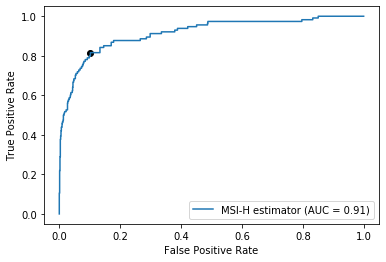

In [151]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MSI-H estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [152]:

precision, recall, thresholds = metrics.precision_recall_curve(t,p)


In [153]:
precision_recall_threshold = np.array(list(zip(precision, recall, thresholds)))
precision_recall_threshold[precision_recall_threshold[:,2] <= 0.70698247]

array([[0.13073394, 1.        , 0.27851355],
       [0.12973594, 0.99122807, 0.27853194],
       [0.13003452, 0.99122807, 0.2786622 ],
       ...,
       [0.86666667, 0.45614035, 0.70530438],
       [0.86440678, 0.44736842, 0.70578396],
       [0.86206897, 0.43859649, 0.70611465]])

In [154]:
best_thresh

0.53181857

In [155]:

precision_recall_threshold[precision_recall_threshold[:,2] == best_thresh]

array([[0.50543478, 0.81578947, 0.53181857]])

In [156]:

fpr, tpr, thresholds = skm.roc_curve(targs[0].cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}')


auc = 0.9149044046704864


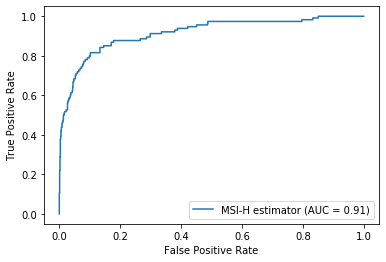

In [157]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MSI-H estimator')
display.plot()  
plt.show() 

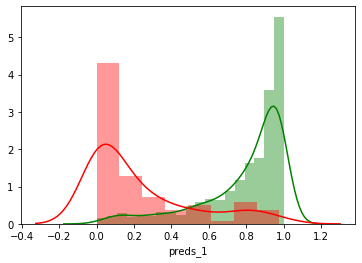

In [158]:
#noexport
import seaborn as sns

df = pd.DataFrame(data=np.c_[preds, targs[0], losses, decoded],
                    columns=['preds_0', 'preds_1','target', 'loss', 'decoded'])
df_normal = df.loc[df.target == 0, 'preds_0']
df_MMR = df.loc[df.target == 1, 'preds_1']
df_MMR = 1 - df_MMR

sns.distplot(df_normal, hist=True,  color = "g")
sns.distplot(df_MMR, hist=True, color = "r")

In [159]:
#noexport
targs[0].cpu().numpy(), preds.float().softmax(dim=-1).cpu()

(array([0, 0, 0, ..., 0, 0, 0]),
 tensor([[0.6191, 0.3809],
         [0.5968, 0.4032],
         [0.6490, 0.3510],
         ...,
         [0.7077, 0.2923],
         [0.6921, 0.3079],
         [0.6778, 0.3222]]))

In [160]:
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(targs[0].cpu().numpy(), decoded.cpu())

array([[780, 111],
       [ 21,  93]])

In [161]:
best_decoded = preds.float().softmax(dim=-1).cpu()[:,1] > best_thresh


In [162]:
skm.confusion_matrix(targs[0].cpu().numpy(), best_decoded)

array([[800,  91],
       [ 22,  92]])

### Agregate prediction by patient

In [163]:

#_d_sub.loc[criteria, 'preds'] = np.array(preds_val)
c['preds'] = np.array(preds_val)
_d_sub.label = _d_sub.label.astype(float)
#_targs = _d_sub.loc[(_d_sub.valid == partition) & ( (_d_sub.project == 'TCGA'))  ].groupby('patient_ID').label.mean().values
#_preds = _d_sub.loc[(_d_sub.valid == partition) & ( (_d_sub.project == 'TCGA')) ].groupby('patient_ID').preds.mean().values
#_targs = _d_sub.loc[criteria ].groupby('patient_ID').label.mean().values
#_preds = _d_sub.loc[criteria ].groupby('patient_ID').preds.mean().values
_targs = c.groupby('patient_ID').label.mean().values
_preds = c.groupby('patient_ID').preds.mean().values

_targs[_targs == 1.0] = 1 
_targs[_targs == 2.0] = 0

_preds = _preds[_targs >= 0]

_targs = _targs[_targs >= 0]
#print(_targs,_preds)

t = _targs #MSS is labeled as 0, MSI as 1
p = _preds
#fpr, tpr, thresholds = skm.roc_curve(_targs,_preds)
#print(t,p)
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'Agregated auc = {auc}, best threshold = {best_thresh}')


_best_decoded = _preds >= best_thresh
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(_targs
                     , _best_decoded)

log_results(_targs,_best_decoded, _preds, agg = 1, hospital = hospital)

Agregated auc = 0.9307816711590295, best threshold = 0.4852462708950043
['model_name', 'agg', 'hosp', 'NPV', 'PPV/Prec', 'Speci/TNR', 'Sensib/TPR', 'f1_MSS', 'f1_MSI', 'n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']
[0.99, 0.58, 0.91, 0.91, 0.95, 0.71, 265, 35, 0.91, 0.83, 242, 23, 3, 32, 0.93]


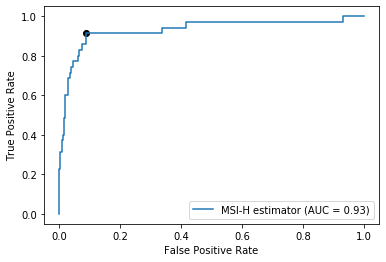

In [164]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MSI-H estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [165]:
h = 1
_targs = c.loc[c.hospital == h].groupby('patient_ID').label.mean().values
_preds = c.loc[c.hospital == h].groupby('patient_ID').preds.mean().values
_targs[_targs == 1.0] = 1 
_targs[_targs == 2.0] = 0
_preds = _preds[_targs >= 0]
_targs = _targs[_targs >= 0]
t = _targs #MSS is labeled as 0, MSI as 1
p = _preds

fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
_best_decoded = _preds >= best_thresh


log_results(_targs,_best_decoded, _preds, agg = 1, hospital = [h])

h = 0
_targs = c.loc[c.hospital == h].groupby('patient_ID').label.mean().values
_preds = c.loc[c.hospital == h].groupby('patient_ID').preds.mean().values
_targs[_targs == 1.0] = 1 
_targs[_targs == 2.0] = 0
_preds = _preds[_targs >= 0]
_targs = _targs[_targs >= 0]
t = _targs #MSS is labeled as 0, MSI as 1
p = _preds

fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
_best_decoded = _preds >= best_thresh


log_results(_targs,_best_decoded, _preds, agg = 1, hospital = [h])

['model_name', 'agg', 'hosp', 'NPV', 'PPV/Prec', 'Speci/TNR', 'Sensib/TPR', 'f1_MSS', 'f1_MSI', 'n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']
[1.0, 0.89, 0.93, 1.0, 0.96, 0.94, 29, 16, 0.97, 0.93, 27, 2, 0, 16, 0.98]
['model_name', 'agg', 'hosp', 'NPV', 'PPV/Prec', 'Speci/TNR', 'Sensib/TPR', 'f1_MSS', 'f1_MSI', 'n_MSS', 'n_MSI', 'bal_accur', 'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']
[0.99, 0.43, 0.91, 0.84, 0.95, 0.57, 236, 19, 0.88, 0.75, 215, 21, 3, 16, 0.89]


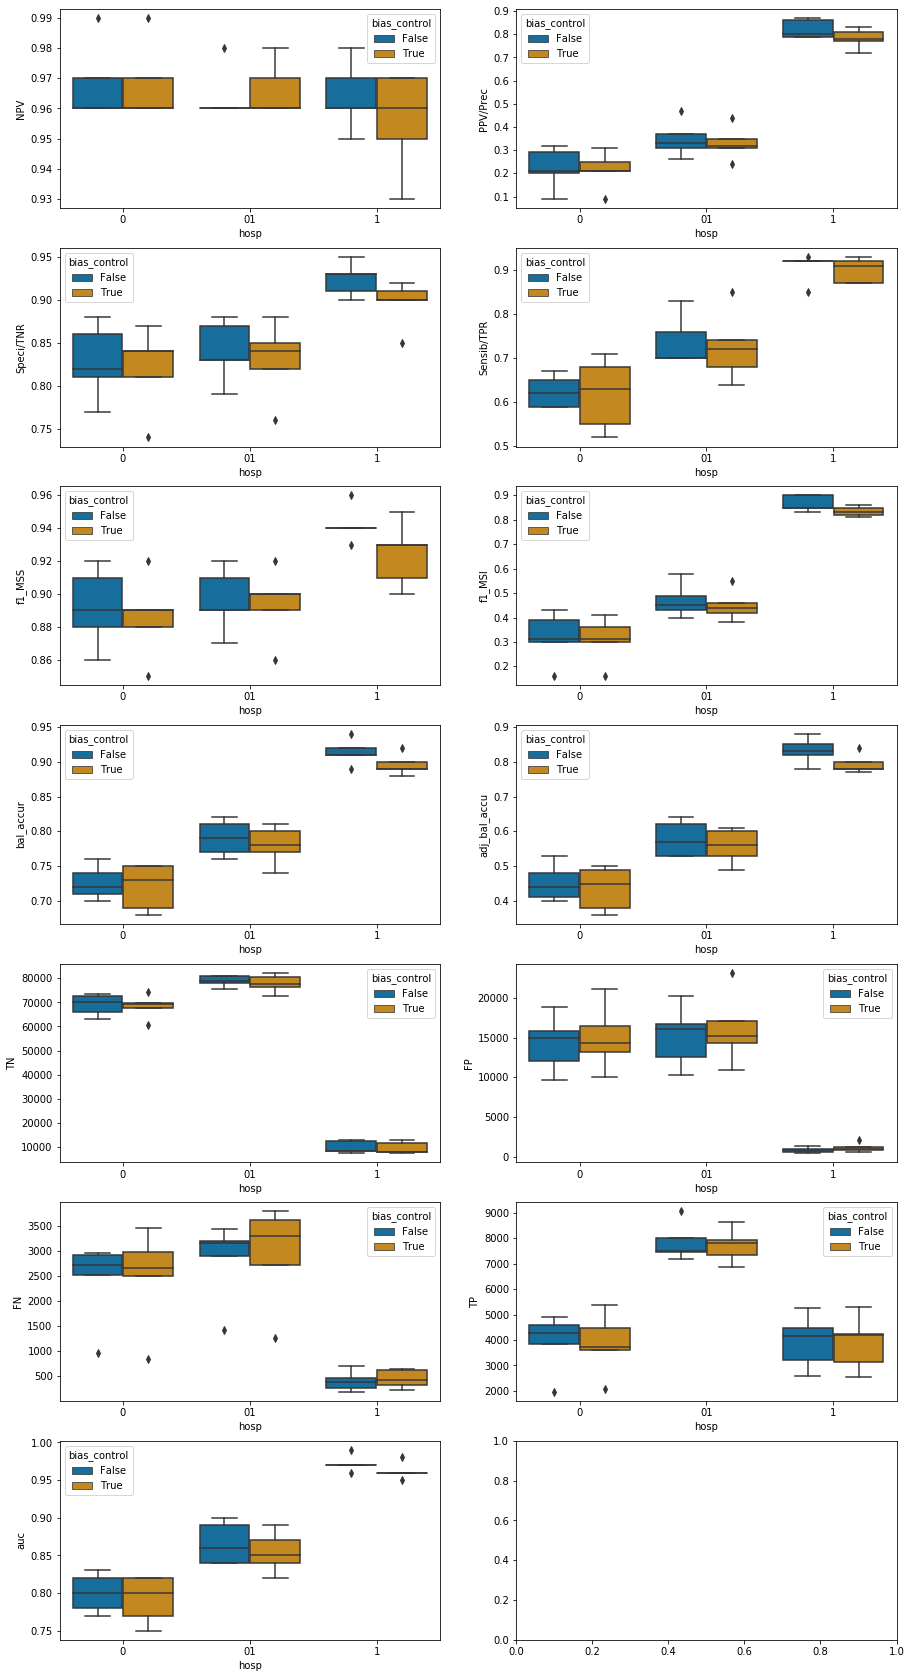

In [103]:
#noexport
def plot_metrics(dff, agg = 0, ablated = False):
    dff['bias_control'] = dff.model_name.str.contains('BiasDistilled=[1, 2, 3]', regex=False) 
    if ablated : 
        dff['ablated'] = dff.model_name.str.contains('ablat', regex=False)
        dff.loc[dff.ablated == True, 'bias_control'] = 2
        dff.loc[dff.bias_control == True, 'bias_control'] = 1
        dff.loc[dff.bias_control == False, 'bias_control'] = 0
        print(dff.bias_control.value_counts())
    else: 
        dff = dff.loc[dff.model_name.str.contains('ablat', regex=False) == False]
    
    
    f, axes = plt.subplots(7, 2, figsize=(15, 30))

    for ax, metric in zip(axes.flatten()[:13], ['NPV', 'PPV/Prec', 'Speci/TNR',
           'Sensib/TPR', 'f1_MSS', 'f1_MSI',  'bal_accur',
           'adj_bal_accu', 'TN', 'FP', 'FN', 'TP', 'auc']):

        sns.boxplot(y=metric, x='hosp', ax = ax,
                         data=dff.loc[(dff['agg'] == agg) ], 
                         palette="colorblind",
                         hue='bias_control')
    plt.show()

dfff = pd.read_csv('results_log/0.01_classification_accuracy.tsv', sep = '\t', dtype = {'hosp' : str}) #frac = 0.01
dfff1 = pd.read_csv('results_log/classification_accuracy.tsv', sep = '\t', dtype = {'hosp' : str}) #frac = 1


plot_metrics(dfff1, agg = 0, ablated = False)


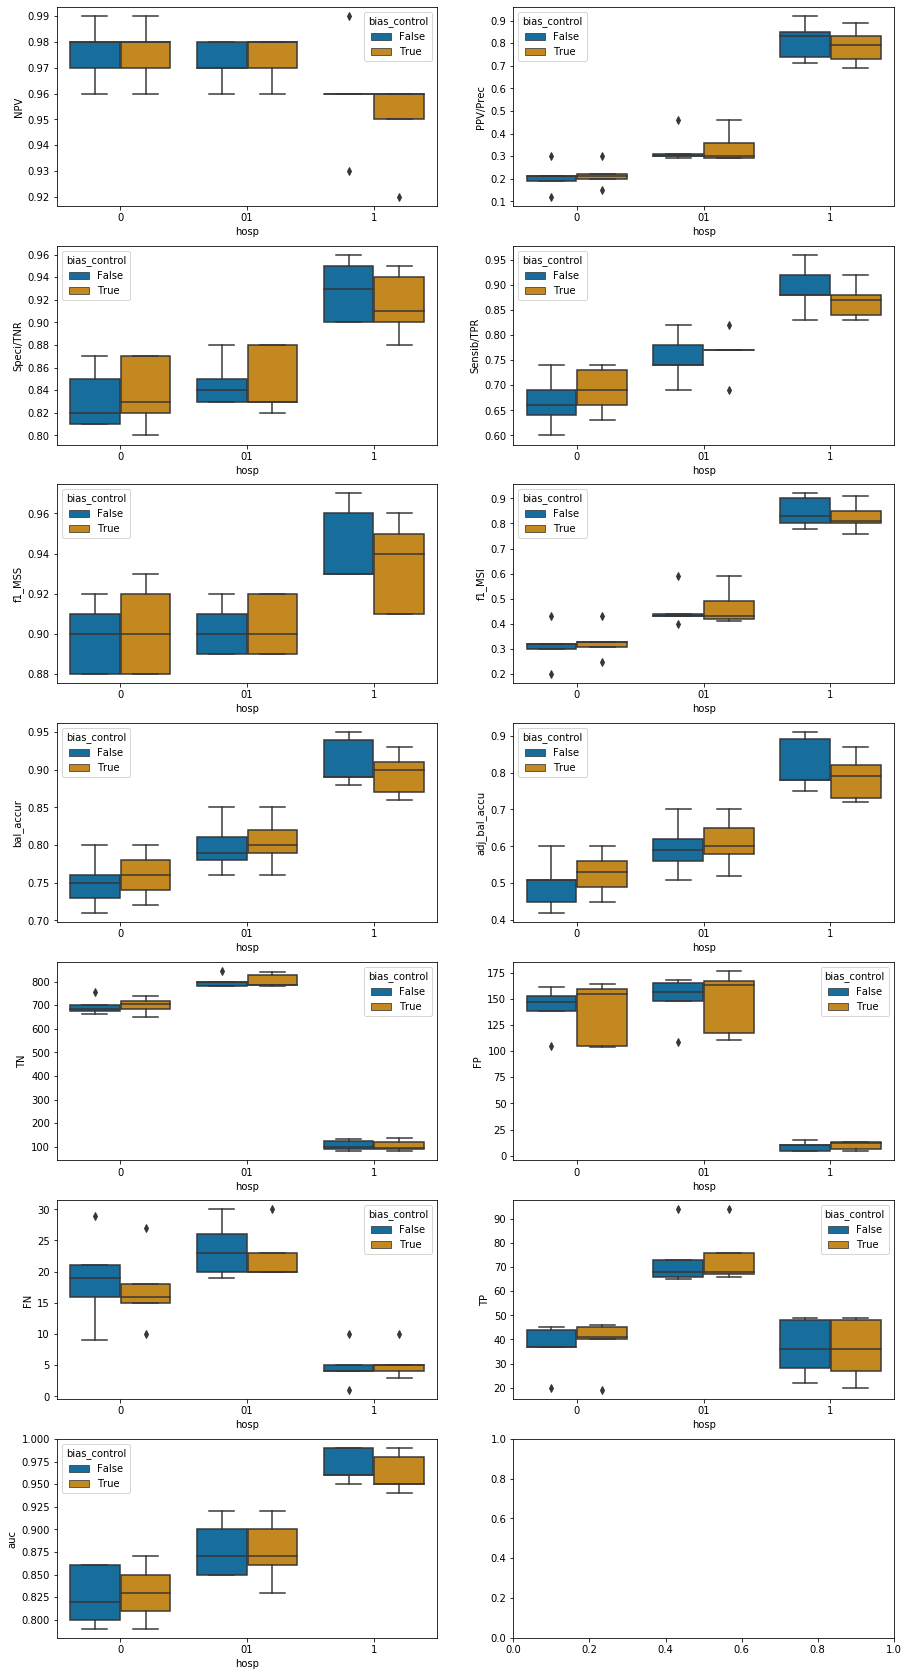

In [96]:
#noexport
plot_metrics(dfff, agg = 0)

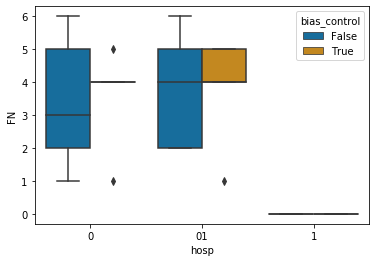

In [36]:
#noexport
sns.boxplot(y=metric, x='hosp', 
                 data=dff.loc[dff['agg'] == 1], 
                 palette="colorblind",
                 hue='bias_control')

# SHAP

In [256]:
#noexport
import shap


In [257]:
#noexport
b=learn.dls[1].one_batch()

In [258]:
#noexport
idx = np.random.choice(bs, size = 1)[0]
id1 = idx
id2 = idx + 20 

images = b[0][id1:id2]
targets = b[1][id1:id2]
bias1 = b[2][id1:id2]
idx, targets, bias1,# images

(62,
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'))

In [259]:
#noexport
learn.model.force_msi = True
out = learn.model.eval()(images)
out.shape


torch.Size([20, 2])

In [260]:
#noexport
preds = Tensor(out.cpu().detach().numpy())
preds = preds.float().softmax(dim=-1).cpu()
preds

tensor([[9.7977e-01, 2.0231e-02],
        [9.9879e-01, 1.2114e-03],
        [9.9615e-01, 3.8482e-03],
        [9.9975e-01, 2.5451e-04],
        [9.8441e-01, 1.5594e-02],
        [8.8698e-01, 1.1302e-01],
        [9.9475e-01, 5.2532e-03],
        [9.8738e-01, 1.2619e-02],
        [9.9813e-01, 1.8741e-03],
        [9.9878e-01, 1.2240e-03],
        [9.9825e-01, 1.7524e-03],
        [9.9879e-01, 1.2095e-03],
        [9.9809e-01, 1.9082e-03],
        [9.9879e-01, 1.2073e-03],
        [9.9941e-01, 5.9485e-04],
        [9.9935e-01, 6.4941e-04],
        [9.9102e-01, 8.9797e-03],
        [9.6654e-01, 3.3459e-02],
        [9.8390e-01, 1.6105e-02],
        [9.9619e-01, 3.8052e-03]])

In [261]:
#noexport
del out
torch.cuda.empty_cache()
gc.collect()


12327

In [262]:
#noexport
images = Tensor(images.cpu()).cuda()
images.shape


torch.Size([20, 3, 300, 300])

In [263]:
#learn.model.force_msi = True
#noexport
e=shap.DeepExplainer(learn.model,images)


In [264]:
#noexport

yb= b[1].cpu()
test_labels = np.array(yb[id1:id2])
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [265]:
#noexport
test_images=images
shap_values = e.shap_values(images)
learn.model.force_msi = False

In [266]:
#noexport
learn.model.force_msi = False

In [267]:
#noexport
denorm = lambda t:Normalize.from_stats(*tissue_stats).decodes(TensorImage(t))

In [268]:
#noexport
shap_numpy = [np.swapaxes(np.swapaxes(denorm(s), 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(denorm(images).cpu().numpy(), 1, -1), 1, 2)
test_numpy.shape

(20, 300, 300, 3)

In [269]:
#noexport
preds, targets, 

(tensor([[9.7977e-01, 2.0231e-02],
         [9.9879e-01, 1.2114e-03],
         [9.9615e-01, 3.8482e-03],
         [9.9975e-01, 2.5451e-04],
         [9.8441e-01, 1.5594e-02],
         [8.8698e-01, 1.1302e-01],
         [9.9475e-01, 5.2532e-03],
         [9.8738e-01, 1.2619e-02],
         [9.9813e-01, 1.8741e-03],
         [9.9878e-01, 1.2240e-03],
         [9.9825e-01, 1.7524e-03],
         [9.9879e-01, 1.2095e-03],
         [9.9809e-01, 1.9082e-03],
         [9.9879e-01, 1.2073e-03],
         [9.9941e-01, 5.9485e-04],
         [9.9935e-01, 6.4941e-04],
         [9.9102e-01, 8.9797e-03],
         [9.6654e-01, 3.3459e-02],
         [9.8390e-01, 1.6105e-02],
         [9.9619e-01, 3.8052e-03]]),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'))

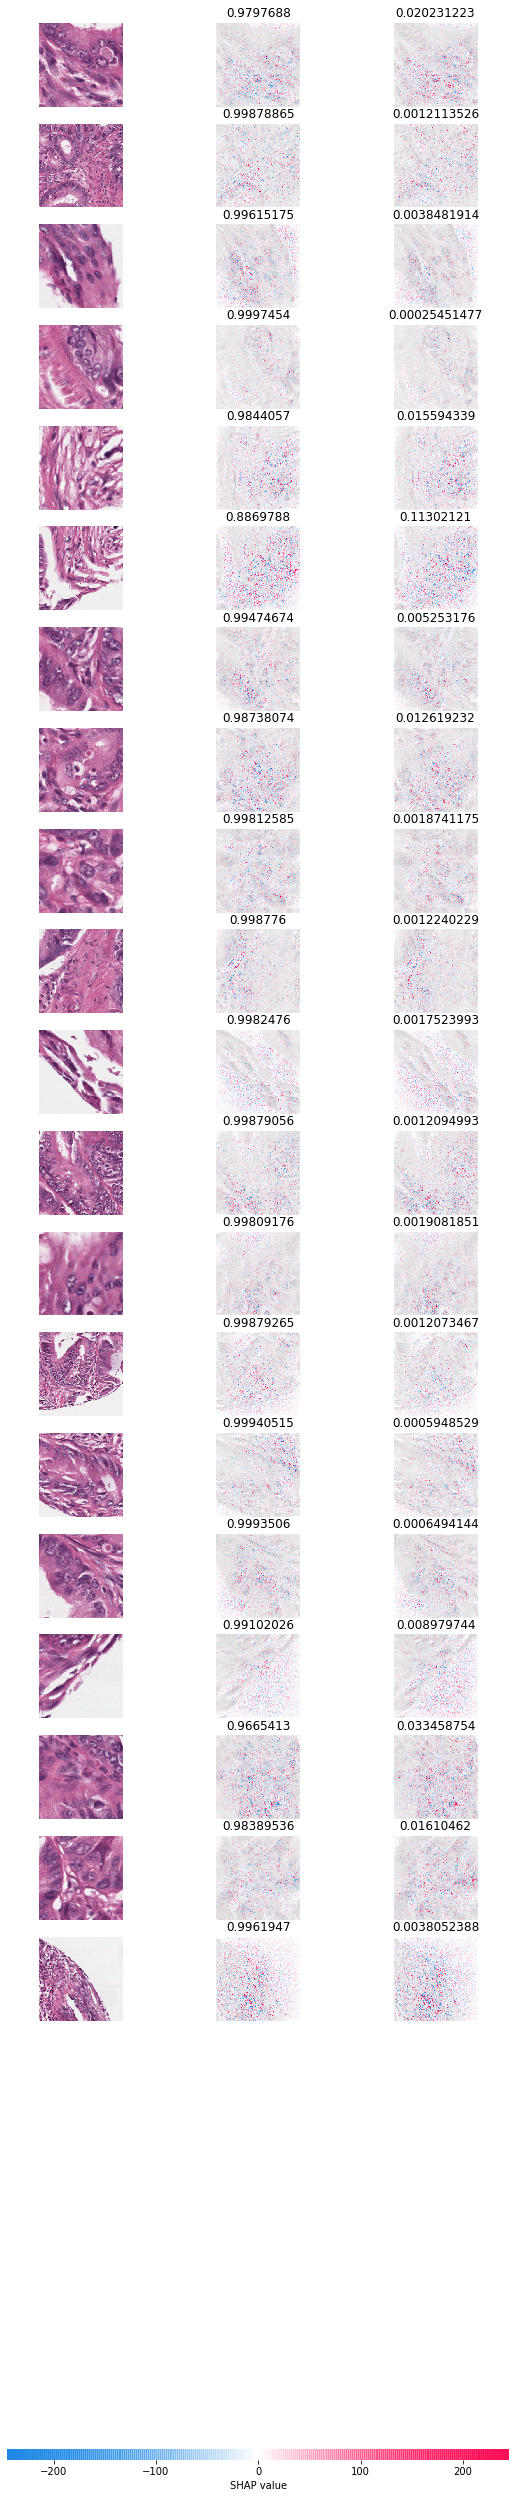

In [270]:
#noexport
shap.image_plot(shap_numpy, test_numpy, labels= preds)